**Introduction**  
Target feature in dataset - **RainTomorrow**, it is binary feature, that takes on two states Yes or No. Thus, in this notebook will be dealt classification problem. Also will be performed data analysis, feature preparation, comparison of built models.

**Independent features:**  
Date - The date of observation

Location - The common name of the location of the weather station

MinTemp - The minimum temperature in degrees celsius

MaxTemp - The maximum temperature in degrees celsius

Rainfall - The amount of rainfall recorded for the day in mm

Evaporation - The so-called Class A pan evaporation (mm) in the 24 hours to 9am

Sunshine - The number of hours of bright sunshine in the day.

WindGustDir - The direction of the strongest wind gust in the 24 hours to midnight

WindGustSpeed - The speed (km/h) of the strongest wind gust in the 24 hours to midnight

WindDir9am - Direction of the wind at 9am

WindDir3pm - Direction of the wind at 3pm

WindSpeed9am - Wind speed (km/hr) averaged over 10 minutes prior to 9am

WindSpeed3pm - Wind speed (km/hr) averaged over 10 minutes prior to 3pm

Humidity9am - Humidity (percent) at 9am

Humidity3pm - Humidity (percent) at 3pm

Pressure9am - Atmospheric pressure (hpa) reduced to mean sea level at 9am

Pressure3pm - Atmospheric pressure (hpa) reduced to mean sea level at 3pm

Cloud9am - Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.

Cloud3pm - Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cload9am for a description of the values

Temp9am - Temperature (degrees C) at 9am

Temp3pm - Temperature (degrees C) at 3pm

RainToday - Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0  
    
**Target feature:**        
RainTomorrow - The amount of next day rain in mm. Used to create response variable RainTomorrow. A kind of measure of the "risk".

**Loading libraries**

In [ ]:
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

**First glance at dataset**

In [ ]:
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/HW3/weatherAUS.csv'

df = pd.read_csv(file_path, sep=',')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

Sorting instances by date in case they are not already.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date', ascending=True)

In [ ]:
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Day'] = pd.to_datetime(df['Date']).dt.day
df.drop('Date', axis=1, inplace=True)

Extrcated data from feature Date, it was seperated onto 3 other columns Year, Month and Day

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145460 entries, 45587 to 145459
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       145460 non-null  object 
 1   MinTemp        143975 non-null  float64
 2   MaxTemp        144199 non-null  float64
 3   Rainfall       142199 non-null  float64
 4   Evaporation    82670 non-null   float64
 5   Sunshine       75625 non-null   float64
 6   WindGustDir    135134 non-null  object 
 7   WindGustSpeed  135197 non-null  float64
 8   WindDir9am     134894 non-null  object 
 9   WindDir3pm     141232 non-null  object 
 10  WindSpeed9am   143693 non-null  float64
 11  WindSpeed3pm   142398 non-null  float64
 12  Humidity9am    142806 non-null  float64
 13  Humidity3pm    140953 non-null  float64
 14  Pressure9am    130395 non-null  float64
 15  Pressure3pm    130432 non-null  float64
 16  Cloud9am       89572 non-null   float64
 17  Cloud3pm       86102 non-null 

In [ ]:
df.duplicated().any()

False

There are no duplicates in dataset

**Missing values**

In [ ]:
def print_missing_values_percentages(df):
    for column in df.columns:
        missing_percentage = df[column].isnull().mean() * 100
        print(f"{column}: {missing_percentage:.2f}%")
print_missing_values_percentages(df)

Location: 0.00%
MinTemp: 1.02%
MaxTemp: 0.87%
Rainfall: 2.24%
Evaporation: 43.17%
Sunshine: 48.01%
WindGustDir: 7.10%
WindGustSpeed: 7.06%
WindDir9am: 7.26%
WindDir3pm: 2.91%
WindSpeed9am: 1.21%
WindSpeed3pm: 2.11%
Humidity9am: 1.82%
Humidity3pm: 3.10%
Pressure9am: 10.36%
Pressure3pm: 10.33%
Cloud9am: 38.42%
Cloud3pm: 40.81%
Temp9am: 1.21%
Temp3pm: 2.48%
RainToday: 2.24%
RainTomorrow: 2.25%
Year: 0.00%
Month: 0.00%
Day: 0.00%


Can be seen that features Cloud9am, Cloud3pm, Sunshine, Evaporation are heavily corrupted with missing values. All other features contain missing values , but in less extent (<= 10%). Features Year, Month, Day do not contain missing data.

In next section will be imputed missing values with strategy: impute missing value with value from previous instance with the same value of feature Location. If there were not such previous instance with valid value, missing value will be imputed from next instance with the same value of feature Location. Such techniques were applied to save the natural dependencies of features, and to introduce outliers to data by imputing every missing value with median value, as such technique would reflect seansonal and locational dependency of metereological conditions.

It could happen that after these techniques applied, missing values will still be presented in some features, nothing to do here, they will imputed with respectful median values of features(for numerical features) and with respectful mode values of features(for categorical features).

In [ ]:
def impute_missing_values_by_location(df, location_column):
    for column in df.columns:
        if column != location_column:
            df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='ffill')).reset_index(level=0, drop=True)
impute_missing_values_by_location(df, "Location")

<ipython-input-9-106cdba5c3f1>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='ffill')).reset_index(level=0, drop=True)
<ipython-input-9-106cdba5c3f1>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='ffill')).reset_index(level=0, drop=True)
<ipython-input-9-106cdba5c3f1>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='ffill')).reset_index(level=0, drop=True)
<ipython-input-9-106cdba5c3f1>:4: FutureWarning: Series.fillna with 'method' is deprecated and will 

In [ ]:
def impute_missing_values_by_location_bfill(df, location_column):
    for column in df.columns:
        if column != location_column:
            df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='bfill')).reset_index(level=0, drop=True)
impute_missing_values_by_location_bfill(df, "Location")

<ipython-input-10-cca29ffe92fe>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='bfill')).reset_index(level=0, drop=True)
<ipython-input-10-cca29ffe92fe>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='bfill')).reset_index(level=0, drop=True)
<ipython-input-10-cca29ffe92fe>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df.groupby(location_column)[column].apply(lambda group: group.fillna(method='bfill')).reset_index(level=0, drop=True)
<ipython-input-10-cca29ffe92fe>:4: FutureWarning: Series.fillna with 'method' is deprecated and w

In [ ]:
def fill_missing_values_median_mode(df):
    for column in df.columns:
        if df[column].dtype == 'float64':
            df[column].fillna(df[column].median(), inplace=True)
        elif df[column].dtype == 'object':
            df[column].fillna(df[column].mode()[0], inplace=True)
fill_missing_values_median_mode(df)

<ipython-input-11-16e7c2d63936>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mode()[0], inplace=True)
<ipython-input-11-16e7c2d63936>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [ ]:
print_missing_values_percentages(df)

Location: 0.00%
MinTemp: 0.00%
MaxTemp: 0.00%
Rainfall: 0.00%
Evaporation: 0.00%
Sunshine: 0.00%
WindGustDir: 0.00%
WindGustSpeed: 0.00%
WindDir9am: 0.00%
WindDir3pm: 0.00%
WindSpeed9am: 0.00%
WindSpeed3pm: 0.00%
Humidity9am: 0.00%
Humidity3pm: 0.00%
Pressure9am: 0.00%
Pressure3pm: 0.00%
Cloud9am: 0.00%
Cloud3pm: 0.00%
Temp9am: 0.00%
Temp3pm: 0.00%
RainToday: 0.00%
RainTomorrow: 0.00%
Year: 0.00%
Month: 0.00%
Day: 0.00%


**Univariate analysis**

In [ ]:
df.describe()

MinTemp        MaxTemp       Rainfall    Evaporation  \
count  145460.000000  145460.000000  145460.000000  145460.000000   
mean       12.212487      23.223688       2.381310       4.897907   
std         6.394937       7.108562       8.488821       3.946079   
min        -8.500000      -4.800000       0.000000       0.000000   
25%         7.600000      18.000000       0.000000       3.000000   
50%        12.000000      22.700000       0.000000       4.200000   
75%        16.900000      28.200000       0.800000       5.600000   
max        33.900000      48.100000     371.000000     145.000000   

            Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  145460.000000  145460.000000  145460.000000  145460.000000   
mean        7.524982      40.094046      14.042802      18.853204   
std         3.003842      13.283481       8.927290       9.064565   
min         0.000000       6.000000       0.000000       0.000000   
25%         6.700000      31.000000       7.000000      13.000000   
50%         7.900000      39.000000      13.000000      19.000000   
75%         9.100000      48.000000      19.000000      24.000000   
max        14.500000     135.000000     130.000000      87.000000   

         Humidity9am    Humidity3pm    Pressure9am    Pressure3pm  \
count  145460.000000  145460.000000  145460.000000  145460.000000   
mean       68.906840      51.463145    1017.620901    1015.260221   
std        19.193947      20.883826       6.761419       6.686770   
min         0.000000       0.000000     980.500000     977.100000   
25%        57.000000      36.000000    1013.500000    1011.000000   
50%        70.000000      52.000000    1017.600000    1015.200000   
75%        83.000000      66.000000    1021.800000    1019.400000   
max       100.000000     100.000000    1041.000000    1039.600000   

            Cloud9am       Cloud3pm        Temp9am        Temp3pm  \
count  145460.000000  145460.000000  145460.000000  145460.000000   
mean        5.004606       4.652922      16.974460      21.687739   
std         2.594852       2.416997       6.500414       6.951000   
min         0.000000       0.000000      -7.200000      -5.400000   
25%         3.000000       3.000000      12.300000      16.600000   
50%         6.000000       5.000000      16.700000      21.200000   
75%         7.000000       7.000000      21.500000      26.400000   
max         9.000000       9.000000      40.200000      46.700000   

                Year          Month            Day  
count  145460.000000  145460.000000  145460.000000  
mean     2012.769751       6.399615      15.712258  
std         2.537684       3.427262       8.794789  
min      2007.000000       1.000000       1.000000  
25%      2011.000000       3.000000       8.000000  
50%      2013.000000       6.000000      16.000000  
75%      2015.000000       9.000000      23.000000  
max      2017.000000      12.000000      31.000000

No numerical features observed with highly small standart deviation value.
Means and medians are almost the same for all numerical features, except for rainfall mean is 2.4 and median is 0, which might suggest us that this dsitribution is skewed to the right. Also it could contain a lot of outliers as we see that most staistics for this column are near 0, except that max reaches very high value comparing to mean or median.
Evaporation might also contain outliers at its maximum value is much bigger than its median.
Can be seen that average temperature at 9 am is lower than at 3 pm, which is natural. Also average windspeed at 9 am is lower than at 3 pm, which is also expected. On average there were 7.5 hours of sunshine every day.

No contradictory feature values can be seen.

In [ ]:
def plot_histograms(df):
    numerical_columns = df.select_dtypes(include=['number']).columns
    for column in numerical_columns:
        plt.figure()
        df[column].hist()
        plt.title(f"Histogram of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

def plot_boxplots(df):
    numerical_columns = df.select_dtypes(include=['number']).columns
    for column in numerical_columns:
        plt.figure()
        df.boxplot(column=column)
        plt.title(f"Boxplot of {column}")
        plt.ylabel(column)
        plt.show()

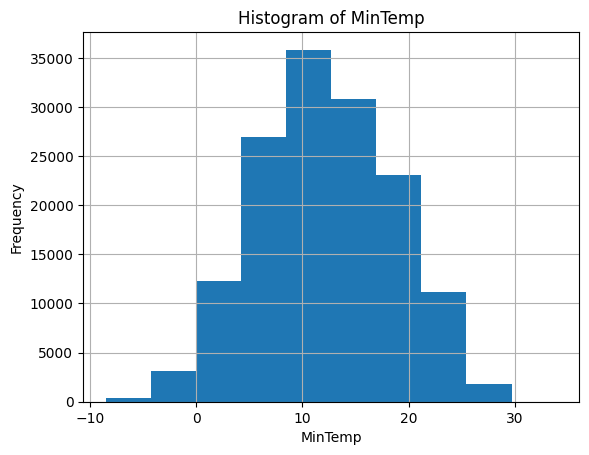

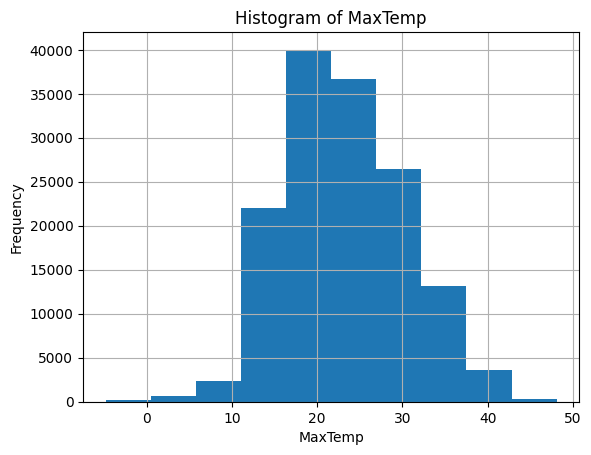

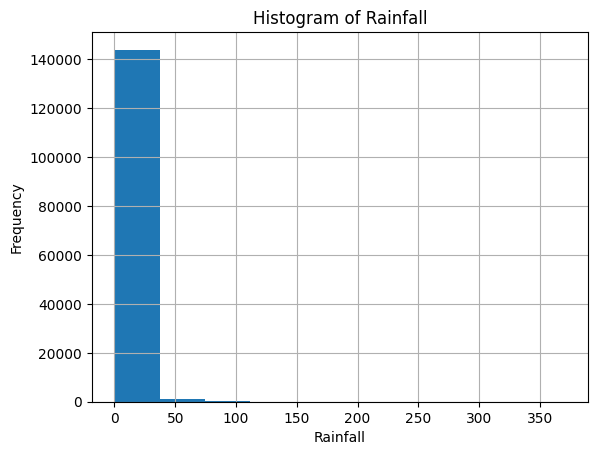

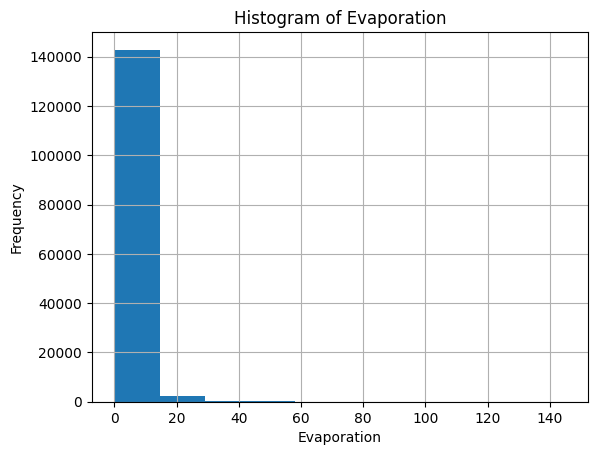

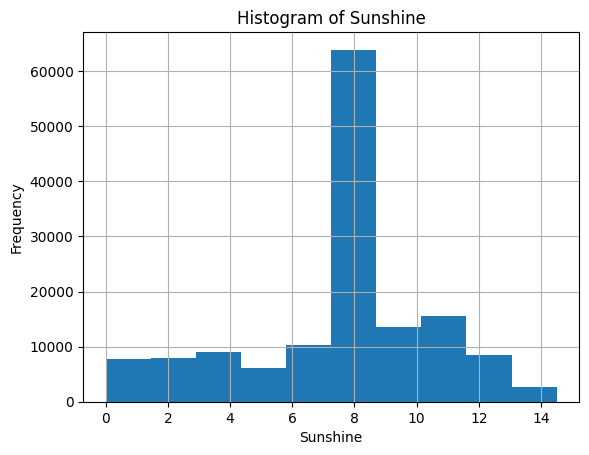

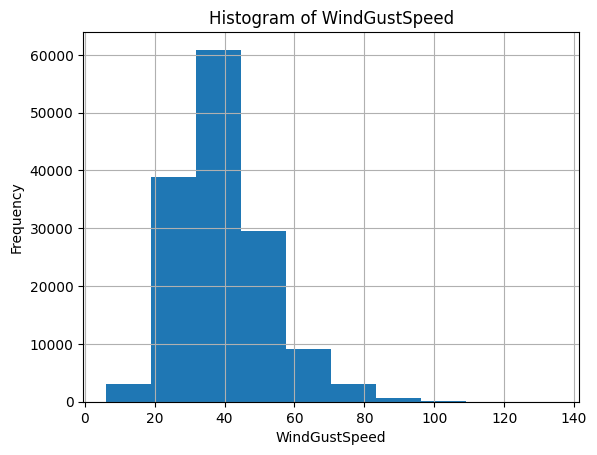

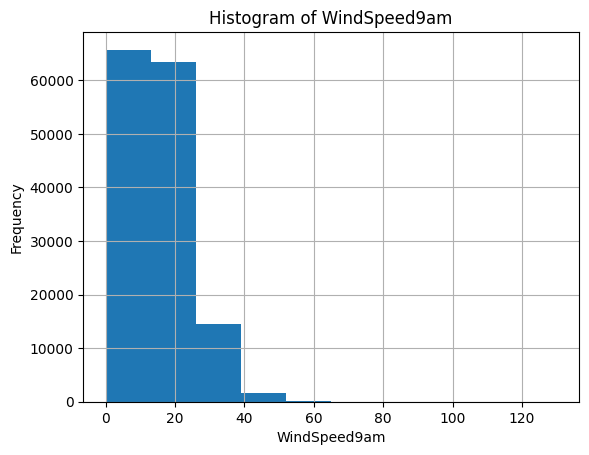

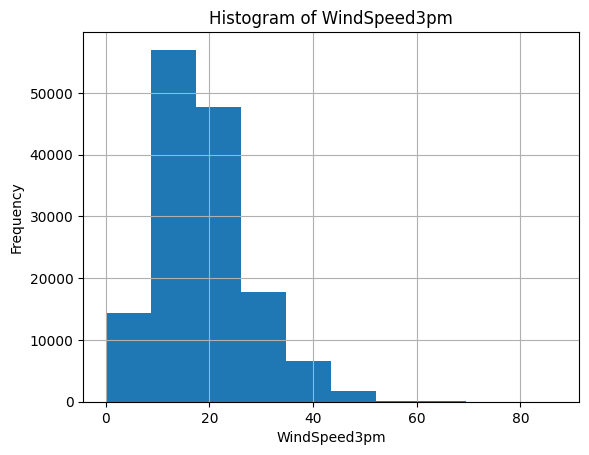

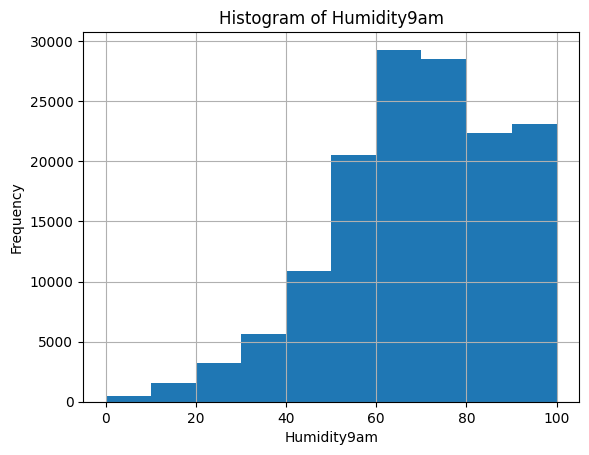

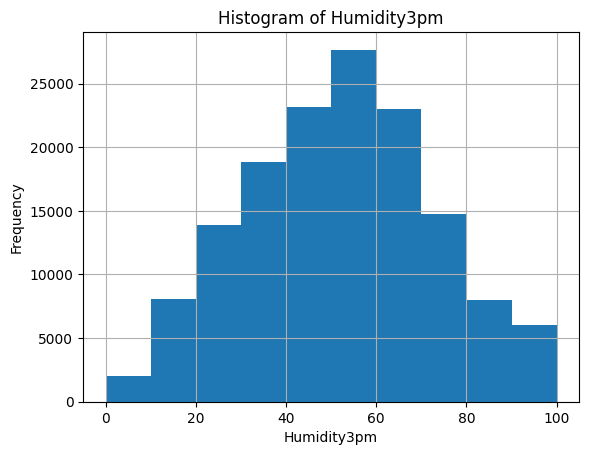

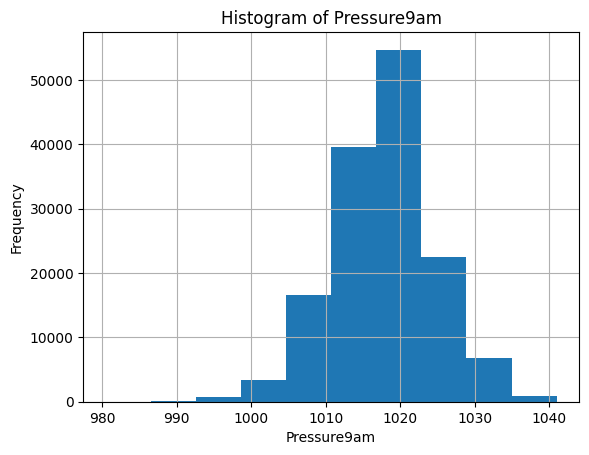

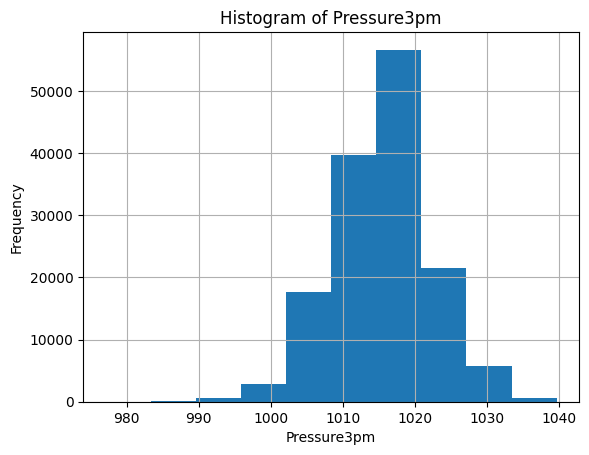

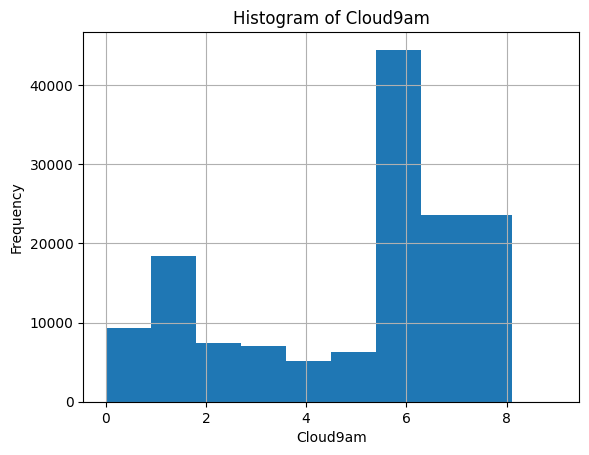

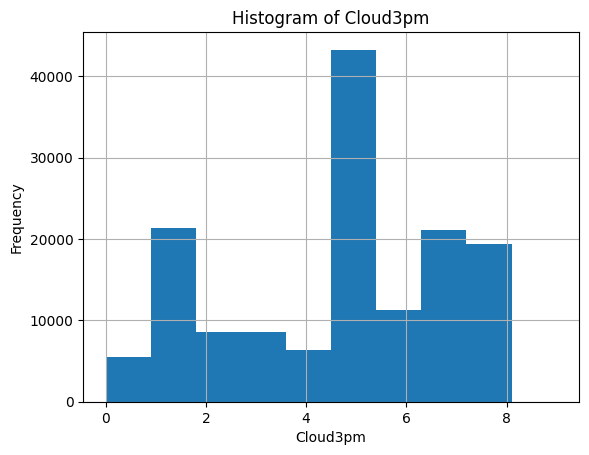

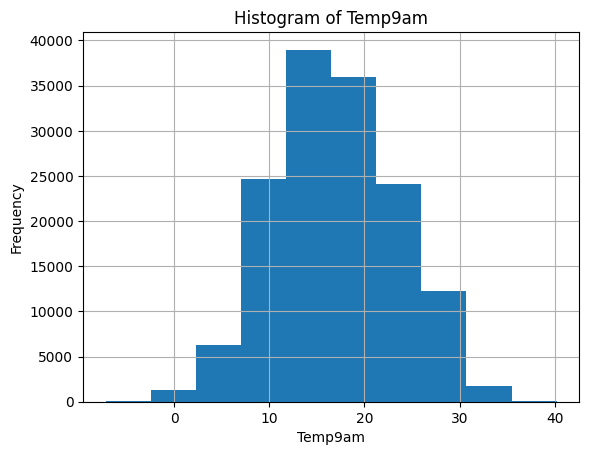

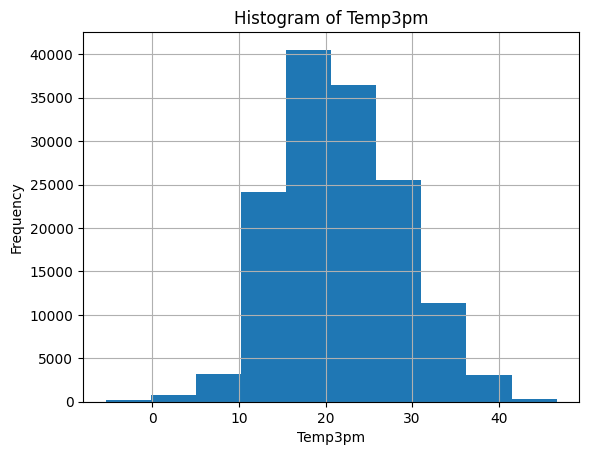

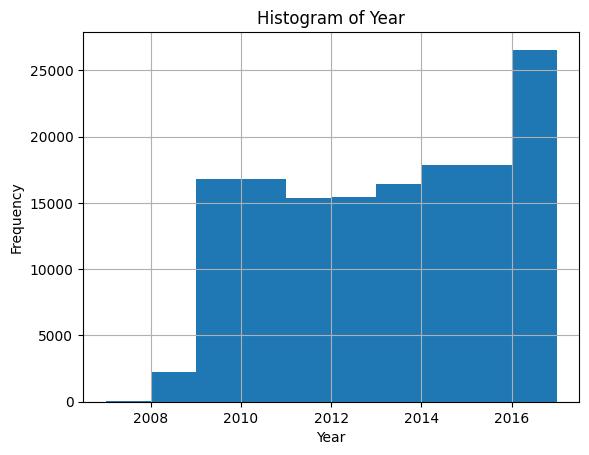

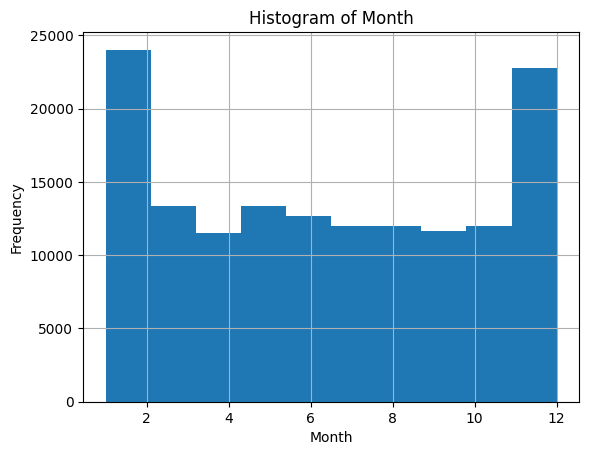

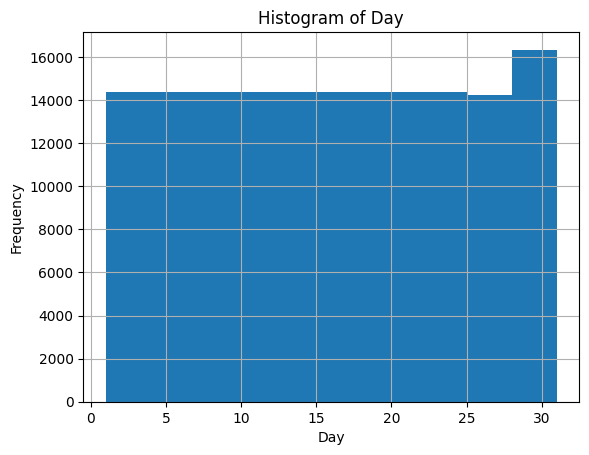

In [ ]:
plot_histograms(df)

Can be seen that MinTemp, MaxTemp, Humidity3pm, Pressure3pm, Pressure9am,Temp9am, Temp3pm features are fairly symmetricaly distributed.  
Distributions of features: rainfall, evaporation, WindGustSpeed, WindSpeed9am, WindSpeed3pm are right skewed.  
Distribution of feature Humidity9am is left skewed.  
Distribution of Sunshine is unimodal, can be seen that mostly values for this feature are around value 8.  
Distributions of features Cloud3pm, Cloud9am are similiar, two peaks can be seen in both, with first one around the same value in both distribution, it is natural to see similiar distrbutions for these features as they are measuring the same quantity, just over different time periods.

For some features that resemble visually normal distribution: MinTemp, Temp3pm, Temp9am, Pressure3pm, Pressure9am,  could be appropriate to use statistical test for normality(Shapiro-Wilk, etc). That notion could be important as when modeling will be used model of Gaussian Naive Bayes, which assumes that numerical features are distributed normally, though it is not very practically. For features that are not distributed normally will be applied normalization, that will at least put scales of every feature at the same range.

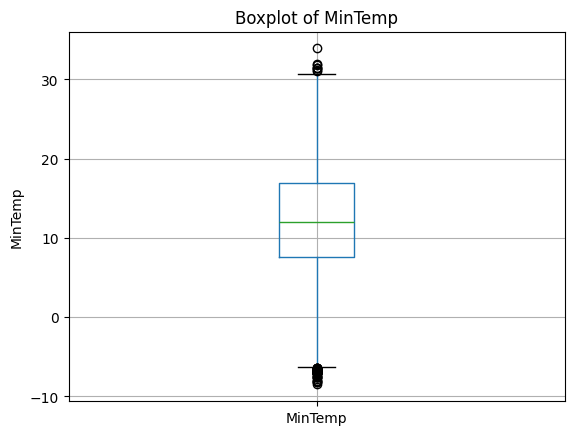

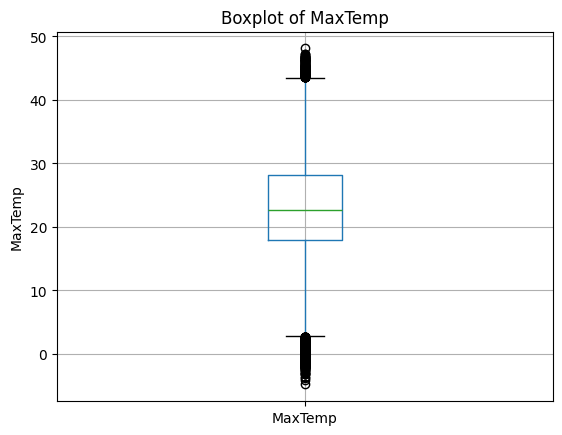

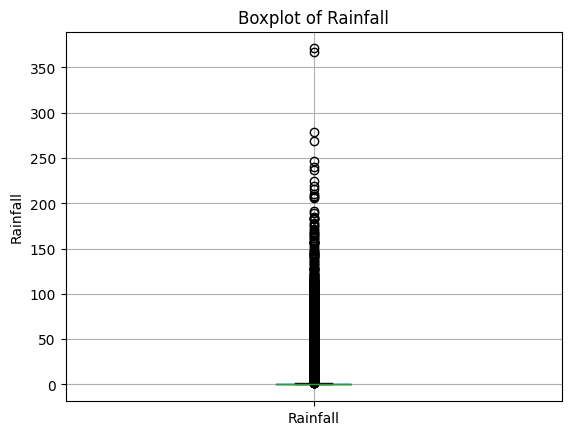

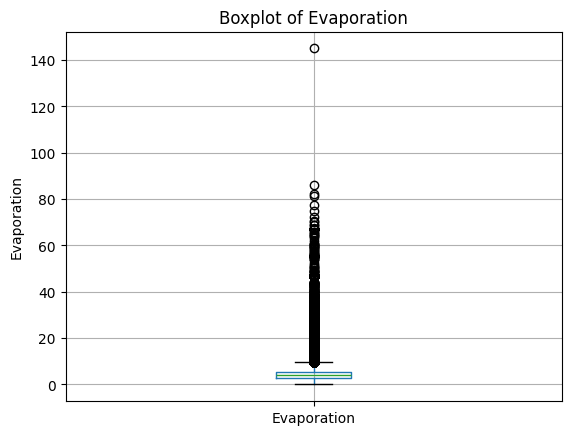

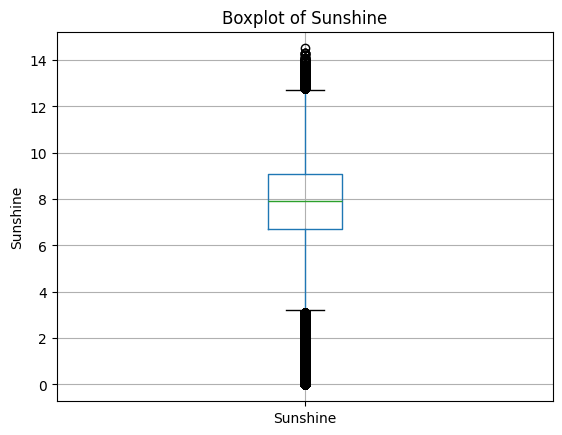

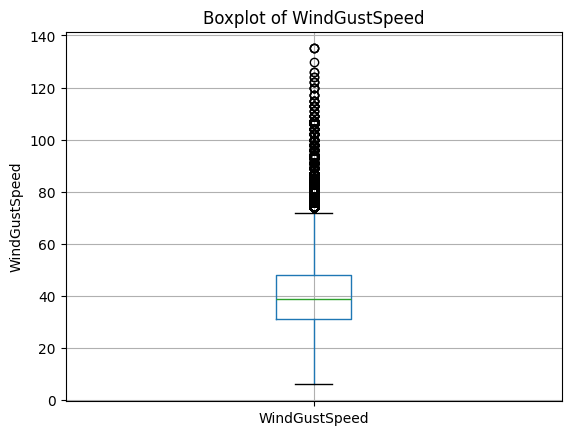

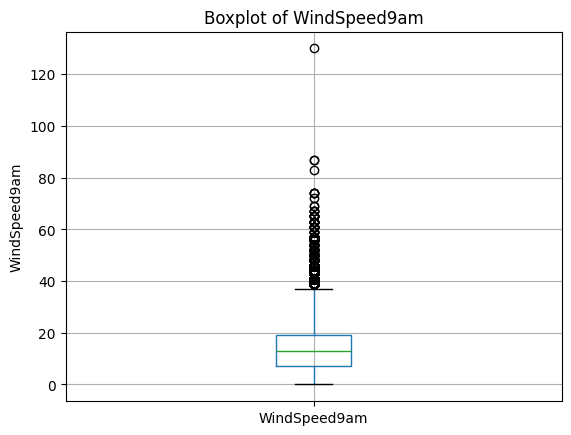

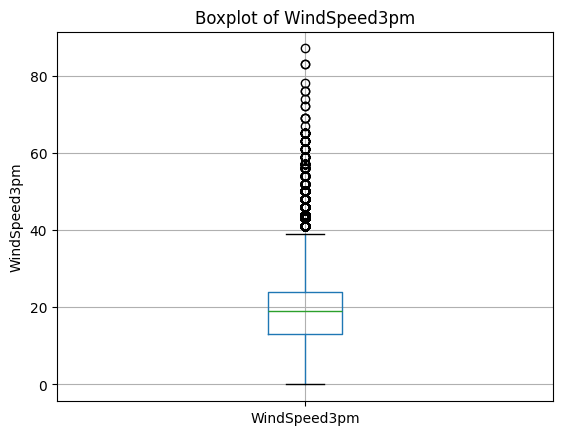

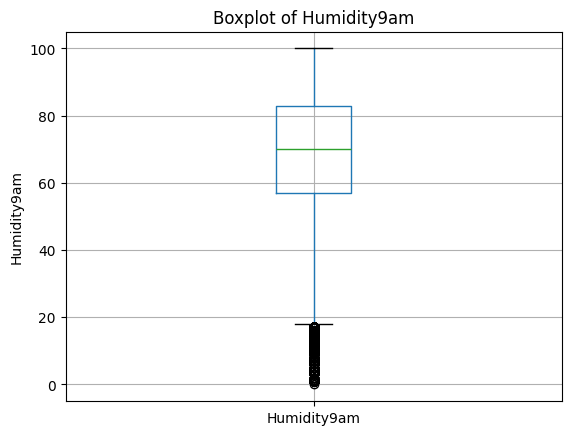

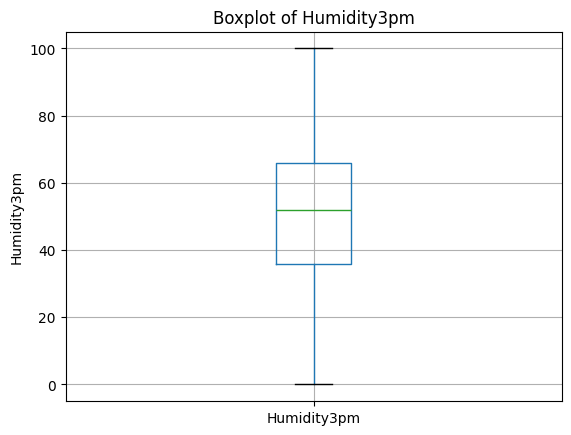

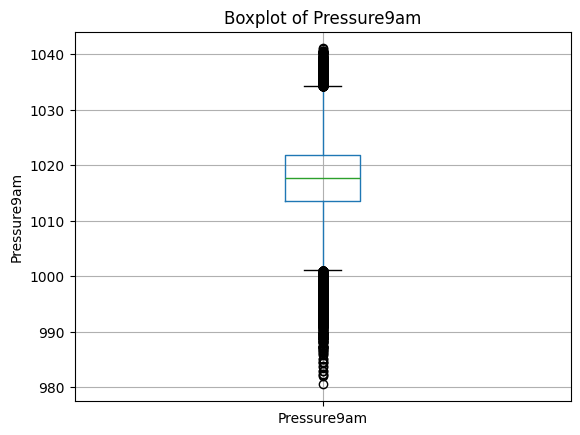

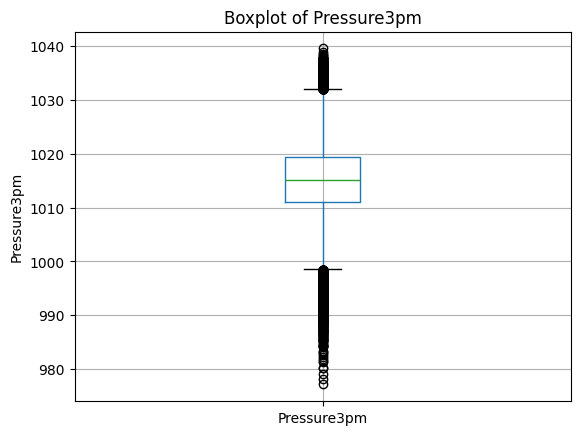

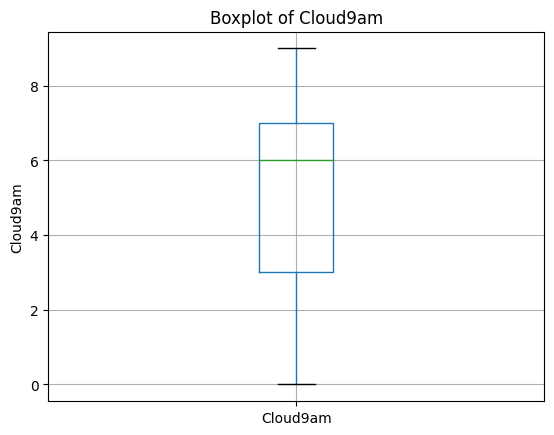

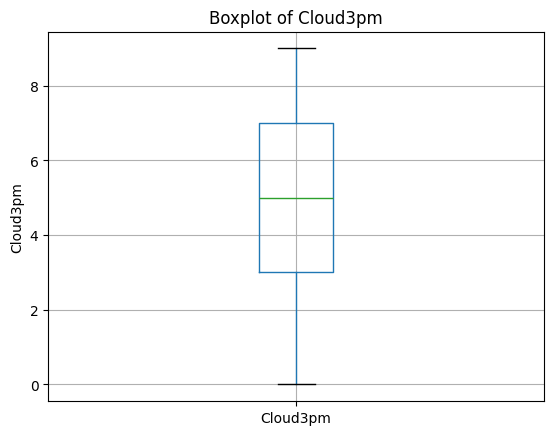

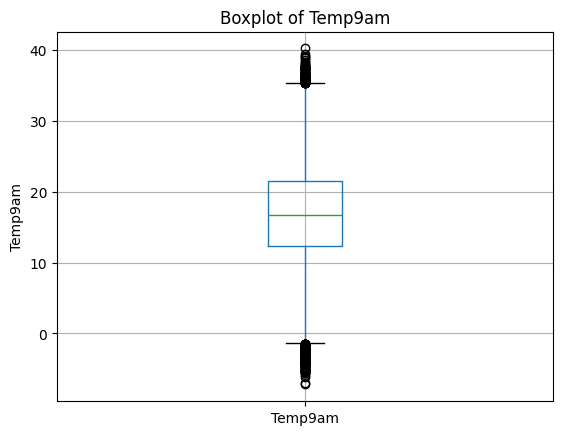

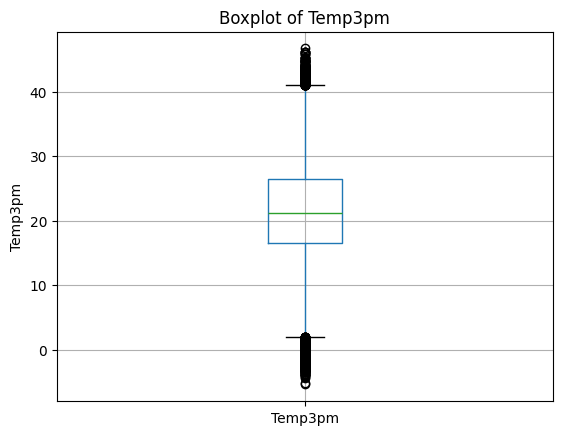

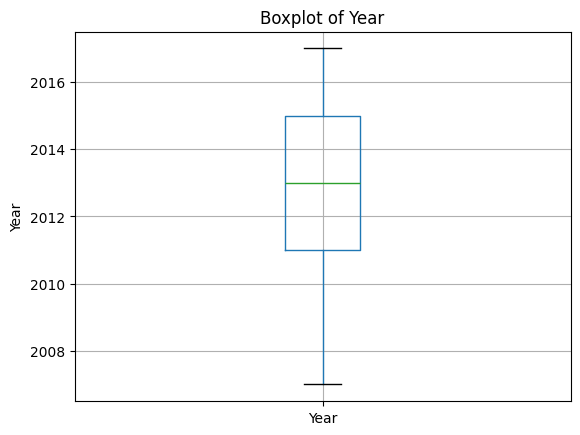

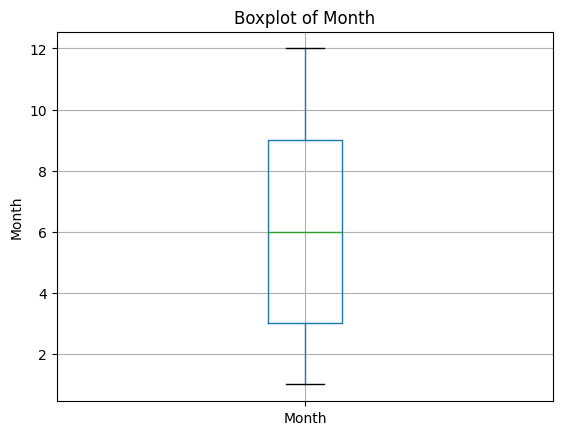

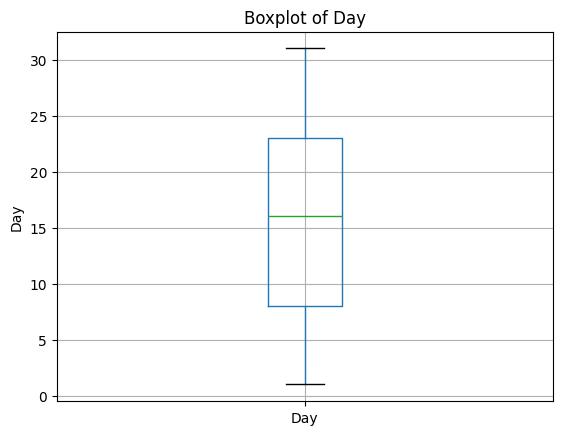

In [ ]:
plot_boxplots(df)

Boxplots generally backed all observations derived from histograms. Also it is noticeable that outliers contain all features except : humidity3pm, cloud9am, cloud3pm, year, month, day.

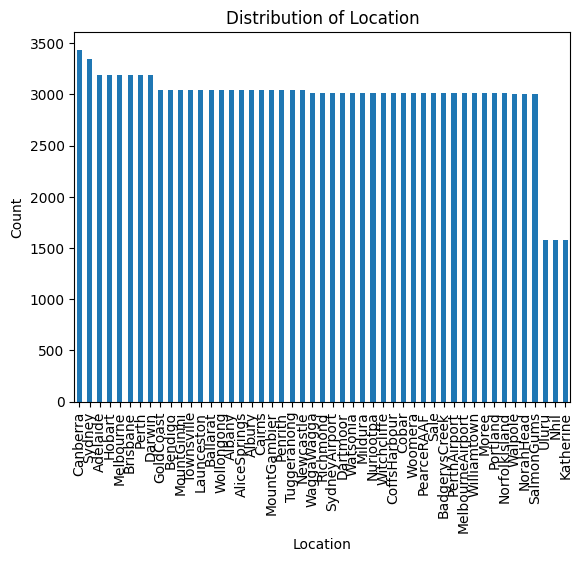

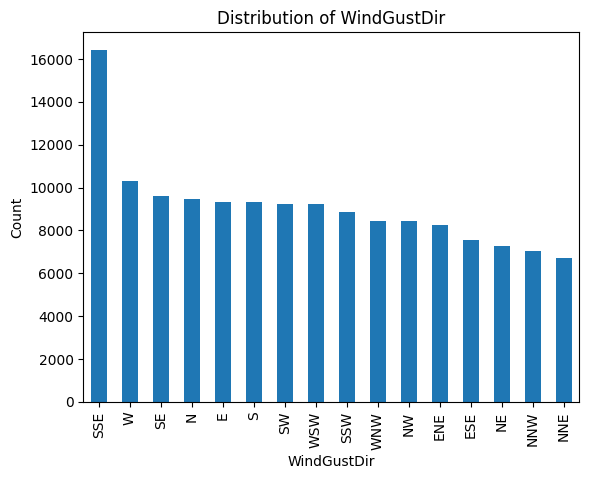

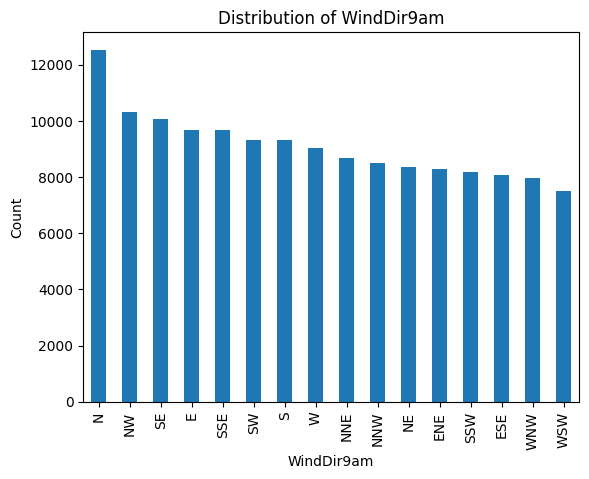

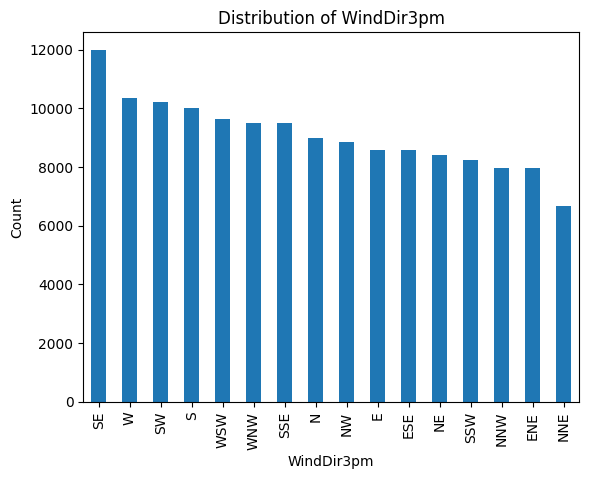

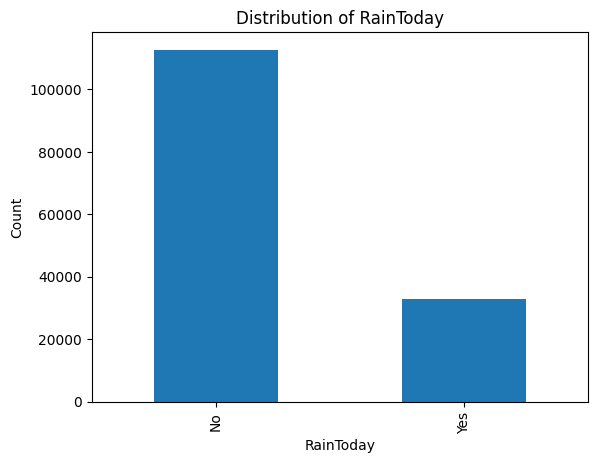

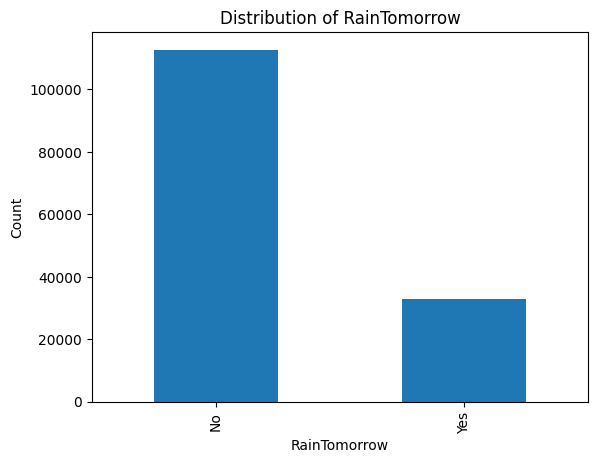

In [ ]:
def plot_categorical_distributions(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    for column in categorical_columns:
        value_counts = df[column].value_counts()
        plt.figure()
        value_counts.plot(kind='bar')
        plt.title(f"Distribution of {column}")
        plt.xlabel(column)
        plt.ylabel("Count")
        plt.show()
plot_categorical_distributions(df)

There is clear class imbalance in target variable(RainTomorrow), with prevailing feature value "No", that was expected. The same can be said about feature (RainToday).  
Almost all location types are equally present in dataset, except: Katherne, Nhil, Uluru, those types in minority.  But overall there is no such high imbalance in values of this feature.
Distribution of categorical features WindDir3pm and WindDir9am(dsicrete) resembles a little bit discrete uniform distrbution, though it can be seen that there are prevailing wind directions in both features ("SE" and "N" respectfully) and it can be seen that frequencies of other values of directions are varying a little bit. But overall there is no such high imbalance in values of this feature.
WindGustDir features has a prevailing value equal to "SSE", frequencies of other values of directions are also varying a little bit. Minor disbalance is present.

In [ ]:
df.Year.unique()

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
      dtype=int32)

In [ ]:
df.Year.value_counts().sort_index()

Year
2007       61
2008     2270
2009    16789
2010    16782
2011    15407
2012    15409
2013    16415
2014    17885
2015    17885
2016    17934
2017     8623
Name: count, dtype: int64

Dataset contains the same number of observations from all years (around 16000), except years 2007, 2008 and 2017. Those last three years have smallest number of recordings in dataset. Instances from those last three years could be considered as outliers, but in this notebook they will be kept, so not to lose important information by deleting instances from those years.

**Multivariate analysis**

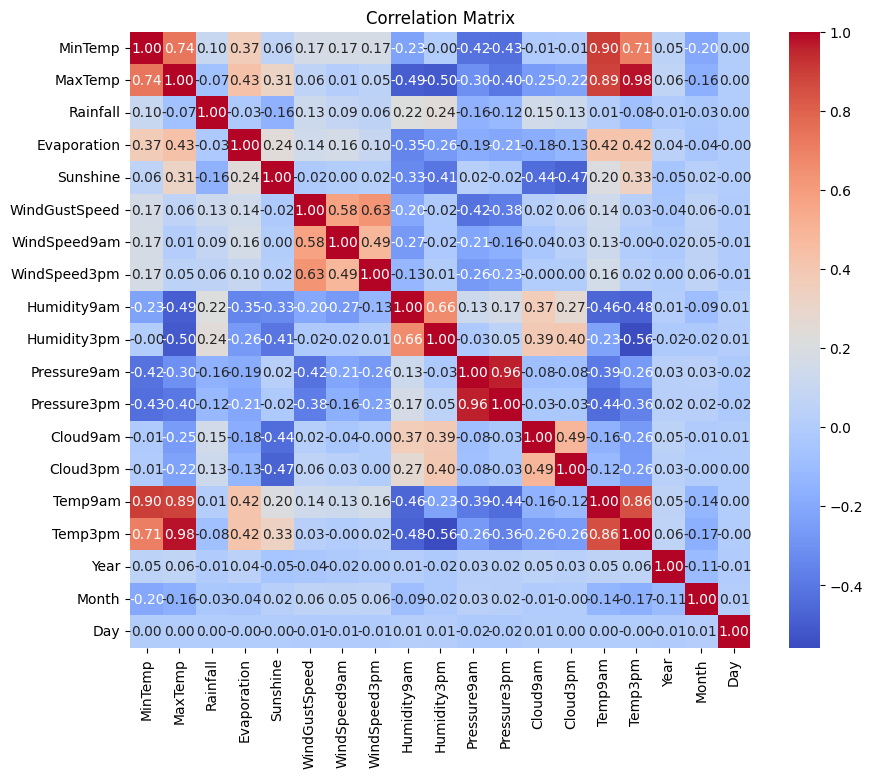

In [ ]:
def plot_correlation_matrix(df):
    numerical_columns = df.select_dtypes(include=['number'])
    correlation_matrix = numerical_columns.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()
plot_correlation_matrix(df)

Can be seen that highly correlated(positevely, linearly) are pairs of features: (Temp9am and MinTemp), (Temp3pm and MinTemp), (Temp9am and MaxTemp), (Temp3pm and MaxTemp), (Temp9am and Temp3pm). All other feature pairs do not appear to be linearly correlated. And again for some of our modeling algorithms will be important that our features are indepenedent (at least linearly) (like for example , it is important assumption of Naive Bayes).

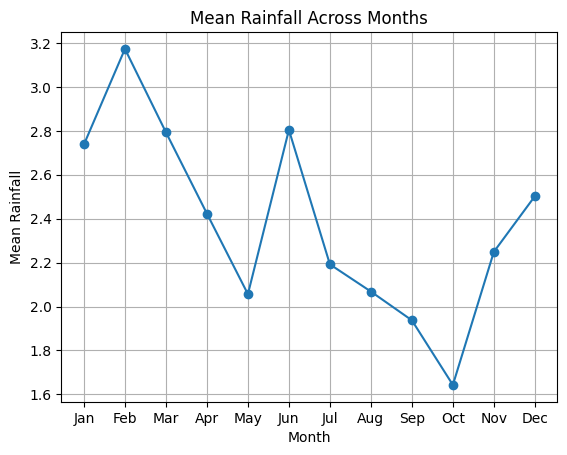

In [ ]:
monthly_mean_rainfall = df.groupby('Month')['Rainfall'].mean()
plt.plot(monthly_mean_rainfall.index, monthly_mean_rainfall.values, marker='o')
plt.title('Mean Rainfall Across Months')
plt.xlabel('Month')
plt.ylabel('Mean Rainfall')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

January, february, march, june appear to have highest mean values of feature rainfall across all other months. That seasonal pattern could be used in modeling, seasonal pattern should be extracted in new feature.

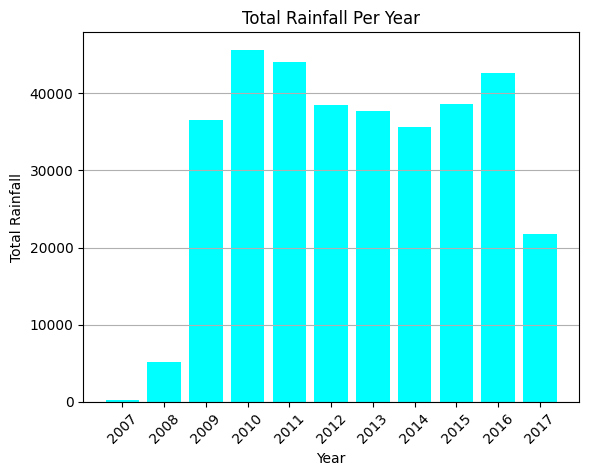

In [ ]:
yearly_rainfall = df.groupby('Year')['Rainfall'].sum()
plt.bar(yearly_rainfall.index, yearly_rainfall.values, color='cyan')
plt.title('Total Rainfall Per Year')
plt.xlabel('Year')
plt.ylabel('Total Rainfall')
plt.xticks(yearly_rainfall.index, rotation=45)
plt.grid(axis='y')
plt.show()

For almost all years the total rainfall quantity is at around the same value (40000). We can see that for this charactersitic outliers are years 2007, 2008, 2017 , but that probably is caused to little observations recorded during them. Can be concluded that specific values for feature Year will not have an impact on target variable, this feature will removed later, as well as feature Day (it seems logical that particular day value does not have any implications on whether it soing to rain tomorrow or not). Seasonal pattern will be taken from feature "Month", using specific formulas. sin_month = sin(2*pi*month/12) , period of such function is 12, which is equal to number of month, similiar transformation will applied to get new feature cos_month = cos(2*pi*month/12), these transfromation will map each month value to two specific unique values. These transormations will preserve cyclical nature of feature month.

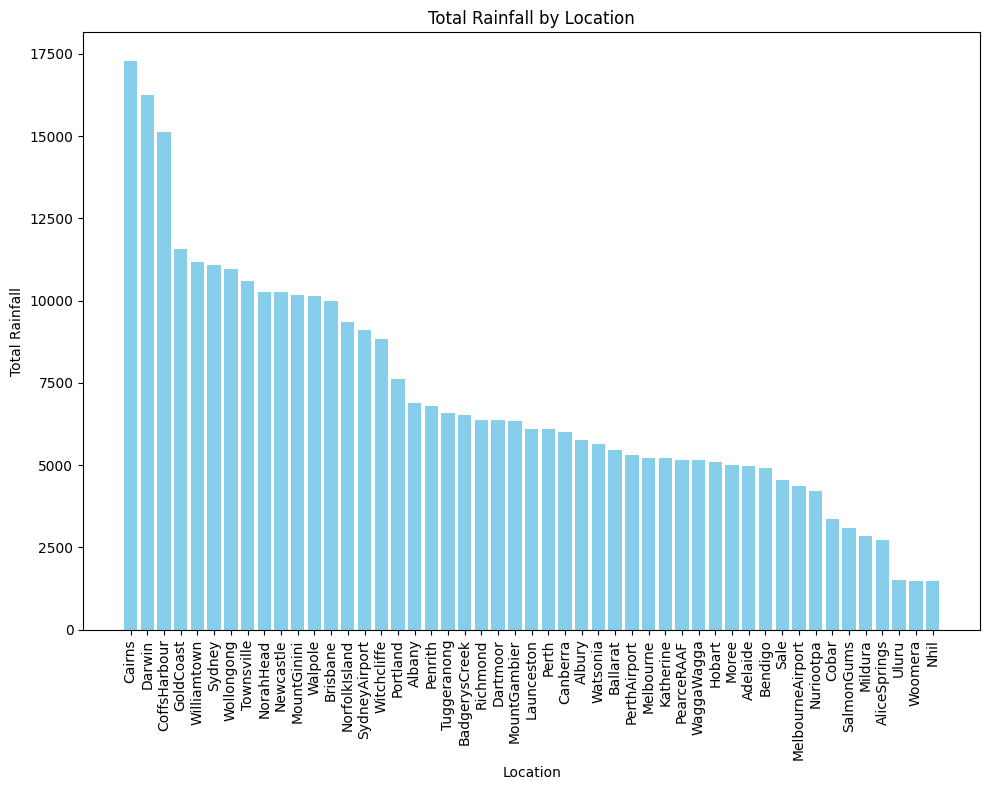

In [ ]:
rainfall_by_city = df.groupby('Location')['Rainfall'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 8))
plt.bar(rainfall_by_city.index, rainfall_by_city.values, color='skyblue')
plt.title('Total Rainfall by Location')
plt.xlabel('Location')
plt.ylabel('Total Rainfall')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Here can be seen total rainfall characteristic grouped by locations, we can see that cities: Cairns, Darwin, Coffs Harbour have the highest total rainfall values. From this assumption can be made that location feature might play relevant role in predicting rainy tomorrows.

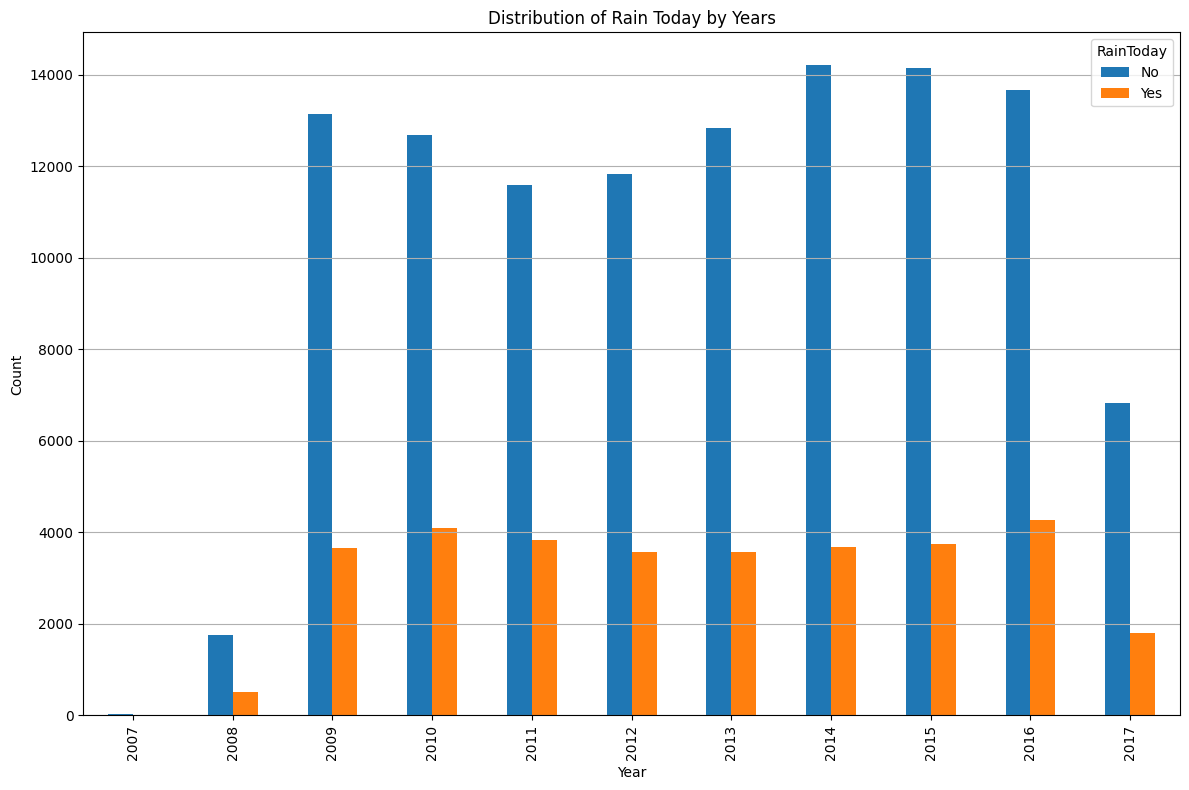

In [ ]:
rain_today_grouped = df.groupby(['Year', 'RainToday']).size().unstack()

rain_today_grouped.plot(kind='bar', figsize=(12, 8), stacked=False)
plt.title('Distribution of Rain Today by Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='RainToday')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Can be concluded that during each year there are more non rainy days. The proportion of non rainy days to rainy days is almost the same across all years(except those years that are in minority in dataset). Is natural, expected depency as rainfalls values should probably not change drastically over the course of years and stay the same, if climate condition is stays the same(global tempreture increasing, etc).

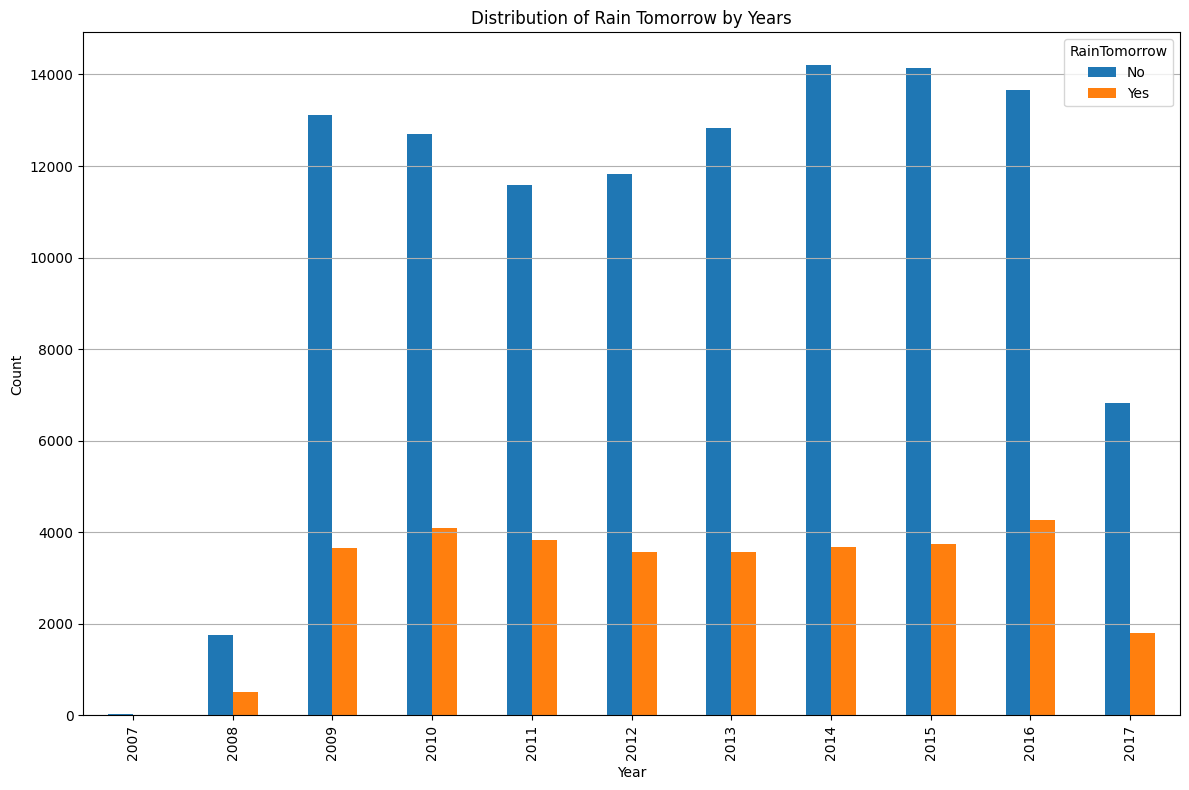

In [ ]:
rain_today_grouped = df.groupby(['Year', 'RainTomorrow']).size().unstack()

rain_today_grouped.plot(kind='bar', figsize=(12, 8), stacked=False)
plt.title('Distribution of Rain Tomorrow by Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='RainTomorrow')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Can be concluded that during each year there are more non rainy "tomorrow" days. The proportion of non rainy "tomorrow" days to rainy "tomorrow" days is almost the same across all years(except those years that are in minority in dataset).

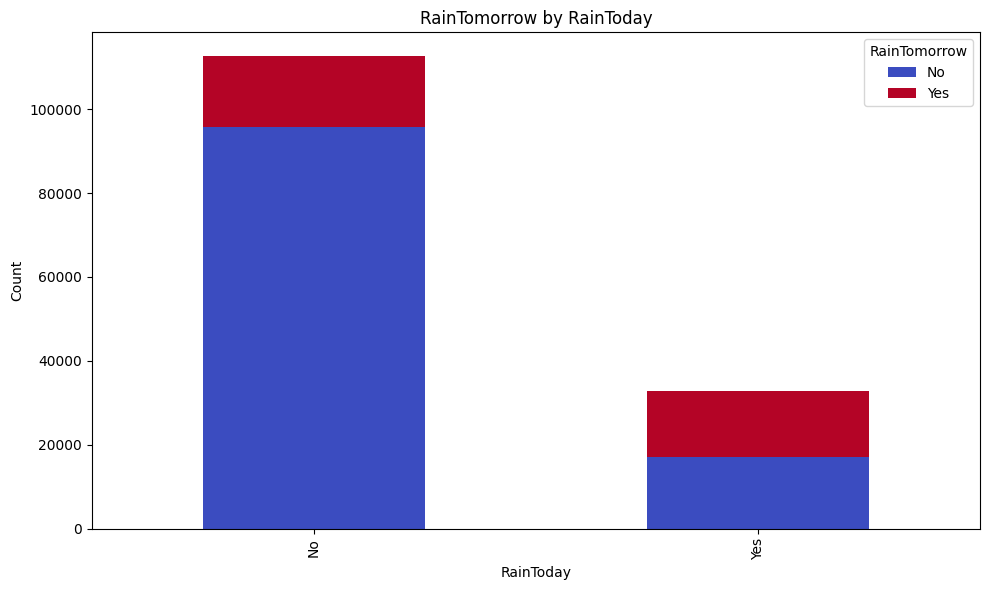

In [ ]:
rain_data_grouped = df.groupby(['RainToday', 'RainTomorrow']).size().unstack()

rain_data_grouped.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title('RainTomorrow by RainToday')
plt.xlabel('RainToday')
plt.ylabel('Count')
plt.legend(title='RainTomorrow')
plt.tight_layout()
plt.show()

Can be seen from plot that it is more likely to rain tomorrow if today was also raining.

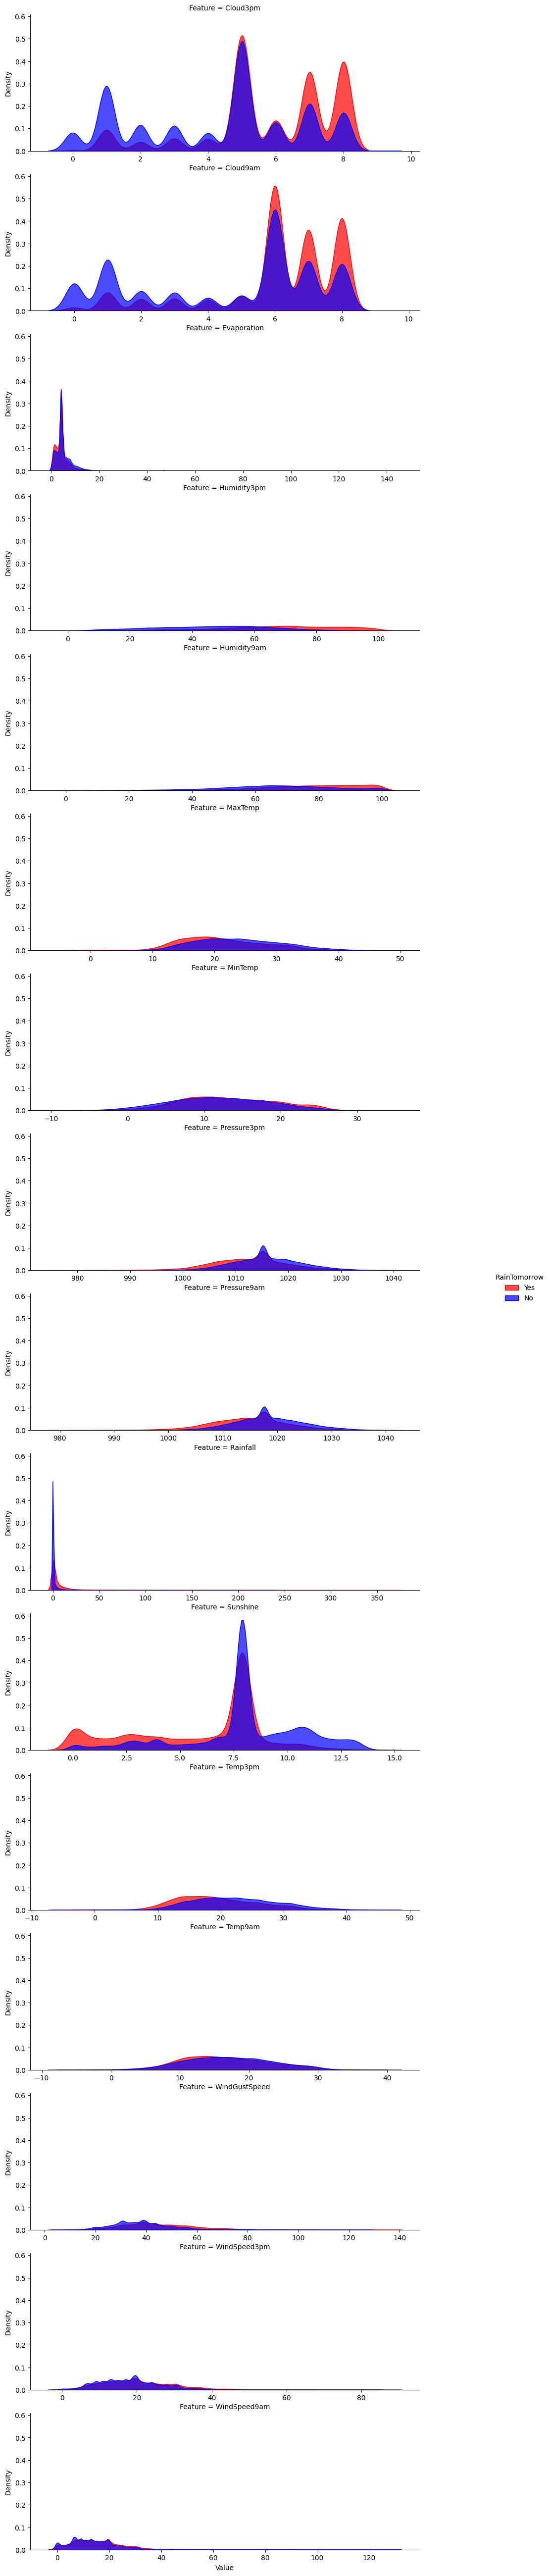

In [ ]:
numerical_columns = df.select_dtypes(include=['number']).columns.difference(['Year', 'Month', 'Day'])
melted_df = df.melt(id_vars=['RainTomorrow'], value_vars=numerical_columns, var_name='Feature', value_name='Value')

g = sns.FacetGrid(melted_df, row='Feature', hue='RainTomorrow', aspect=3, height=4, sharex=False, palette={'Yes': 'red', 'No': 'blue'})
g.map(sns.kdeplot, 'Value', fill=True, alpha=0.7).add_legend()

plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.1)
plt.show()

Can be seen , that:  
1) it is more likely that it will be raining tomorrow if fraction of sky at 3pm obscured by cloud was of value bigger than 4.2, and it is more likely that it is not going to rain tomorrow if fraction of sky obscured by cloud at 3pm was of value less than 4.2  
2) it is more likely that it will be raining tomorrow if fraction of sky at 9am obscured by cloud was of value bigger than 5.7, and it is more likely that it is not going to rain tomorrow if fraction of sky obscured by cloud at 9am was of value less than 5.7  
3) it is more likely that it will rain tomorrow if evaporation was of small value today  
4) It is much likely that it is going to be raining tomorrow if today's humidity at 3pm was higher than value 60.  
5) It is much likely that it is going to be raining tomorrow if today's humidity at 9am was higher than value 80.  
6) It is more likely that it is going to be raining tomorrow if today's maximal temperature was lower than value 20.  
7) Nothing significant can be concluded for feature minimum temperature, as distributions of minimal temperature are fairly the same for two labels of feature RainTomorrow.  
8) It is more likely that it is going to be raining tomorrow if today's pressure at 3pm was lower than value 1012.  
9) It is more likely that it is going to be raining tomorrow if today's pressure at 9am was lower than value 1015.  
10) It is more likely that it is going to be raining tomorrow if today's rainfall value was not around zero value.  
11) It is more likely that it is going to be raining tomorrow if today sun was shining less than 7.5 hours.  
12) It is more likely that it is going to be raining tomorrow if today's temerature at 3pm was lower than value 19.  
13) More likely tempreture value at 9 am does not strnogly affect tomorrow's probability of raining.  
14) It is more likely that it is going to be raining tomorrow if today's windgustspeed was higher than value 42.  
15) It is more likely that it is going to be raining tomorrow if today's windspeed at 3pm was higher than value 22.  
16) It is more likely that it is going to be raining tomorrow if today's windspeed at 9am was in between values of 20 and 90.  

Conclusion: in most cases distrbution of features divided by values of feature RainTomorrow are very similiar, and mostly are fairly overlapped, without clear separation and clear strong specific value dependencies on target feature.

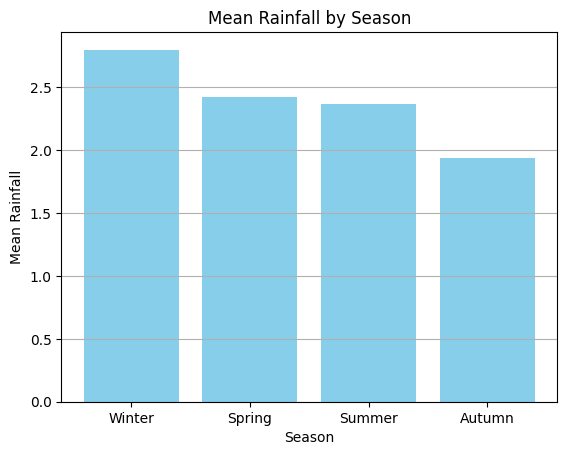

In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(get_season)

seasonal_mean_rainfall = df.groupby('Season')['Rainfall'].mean().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

plt.bar(seasonal_mean_rainfall.index, seasonal_mean_rainfall.values, color='skyblue')
plt.title('Mean Rainfall by Season')
plt.xlabel('Season')
plt.ylabel('Mean Rainfall')
plt.grid(axis='y')
plt.show()

df.drop('Season', axis=1, inplace=True)

Mean rainfall is highest suring winter, and lowest during autumn, that suggest that during winter rains are more frequent and stronger, and opposite can be said about autumn season.

**Encoding**

Categorical features ("Location", "WindGustDir", "WindDir9am", "WindDir3pm")
will be encoded with one hot encoding method, as no ordinality can be introduced on them.  
Features RainToday and RainTomorrow will be encoded with rule: "Yes"-> 1 , "No" -> 0, as these features are basically binary.

In [ ]:
categorical_features = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm"]
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

As we have seen in EDA there is a relationship betweeen month of the year and amount of rainfalls. So it is better to use this information in models. Month feature will be transformed by applying sin and cos functions. Two new features will be added to daatset after this.
Features Year, Day, will no be used in modeling(will be deleted right before modeling). As they do not contain relevant useful information for modeling.

In [ ]:
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
45587      8.0     24.3       0.0          3.4       6.3           30.0   
45588     14.0     26.9       3.6          4.4       9.7           39.0   
45589     13.7     23.4       3.6          5.8       3.3           85.0   
45590     13.3     15.5      39.8          7.2       9.1           54.0   
45591      7.6     16.1       2.8          5.6      10.6           50.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
45587           6.0          20.0         68.0         29.0  ...   
45588           4.0          17.0         80.0         36.0  ...   
45589           6.0           6.0         82.0         69.0  ...   
45590          30.0          24.0         62.0         56.0  ...   
45591          20.0          28.0         68.0         49.0  ...   

       WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  WindDir3pm_SSW  \
45587         False          False           False           False   
45588         False          False           False           False   
45589         False          False           False           False   
45590         False          False           False           False   
45591         False          False           False           False   

       WindDir3pm_SW  WindDir3pm_W  WindDir3pm_WNW  WindDir3pm_WSW  Month_sin  \
45587          False         False           False           False       -0.5   
45588          False          True           False           False       -0.5   
45589          False         False           False           False       -0.5   
45590          False          True           False           False       -0.5   
45591          False         False           False           False       -0.5   

       Month_cos  
45587   0.866025  
45588   0.866025  
45589   0.866025  
45590   0.866025  
45591   0.866025  

[5 rows x 116 columns]

**Normalization**

Values in different columns of dataframe are in different scales. The fact that one feature is in greater scale(range) could make an artificial high impact of this feature on predicting target values. To prevent that, normalization will be applied.

In [ ]:
numerical_features = df.select_dtypes(include=['number']).columns.difference(["Year", "Day", "Month"])

scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
45587  0.389151  0.550095  0.000000     0.023448  0.434483       0.186047   
45588  0.530660  0.599244  0.009704     0.030345  0.668966       0.255814   
45589  0.523585  0.533081  0.009704     0.040000  0.227586       0.612403   
45590  0.514151  0.383743  0.107278     0.049655  0.627586       0.372093   
45591  0.379717  0.395085  0.007547     0.038621  0.731034       0.341085   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
45587      0.046154      0.229885         0.68         0.29     0.647934   
45588      0.030769      0.195402         0.80         0.36     0.527273   
45589      0.046154      0.068966         0.82         0.69     0.479339   
45590      0.230769      0.275862         0.62         0.56     0.413223   
45591      0.153846      0.321839         0.68         0.49     0.624793   

       Pressure3pm  Cloud9am  Cloud3pm   Temp9am   Temp3pm  RainToday  \
45587       0.6064  0.777778  0.777778  0.455696  0.556622        0.0   
45588       0.5008  0.555556  0.333333  0.521097  0.596929        1.0   
45589       0.4816  0.888889  0.777778  0.476793  0.491363        1.0   
45590       0.4784  0.222222  0.777778  0.436709  0.374280        1.0   
45591       0.6624  0.777778  0.777778  0.386076  0.399232        1.0   

       RainTomorrow  Year  Month  Day  Location_Albany  Location_Albury  \
45587           1.0  2007     11    1            False            False   
45588           1.0  2007     11    2            False            False   
45589           1.0  2007     11    3            False            False   
45590           1.0  2007     11    4            False            False   
45591           0.0  2007     11    5            False            False   

       Location_AliceSprings  Location_BadgerysCreek  Location_Ballarat  \
45587                  False                   False              False   
45588                  False                   False              False   
45589                  False                   False              False   
45590                  False                   False              False   
45591                  False                   False              False   

       Location_Bendigo  Location_Brisbane  Location_Cairns  \
45587             False              False            False   
45588             False              False            False   
45589             False              False            False   
45590             False              False            False   
45591             False              False            False   

       Location_Canberra  Location_Cobar  Location_CoffsHarbour  \
45587               True           False                  False   
45588               True           False                  False   
45589               True           False                  False   
45590               True           False                  False   
45591               True           False                  False   

       Location_Dartmoor  Location_Darwin  Location_GoldCoast  \
45587              False            False               False   
45588              False            False               False   
45589              False            False               False   
45590              False            False               False   
45591              False            False               False   

       Location_Hobart  Location_Katherine  Location_Launceston  \
45587            False               False                False   
45588            False               False                False   
45589            False               False                False   
45590            False               False                False   
45591            False               False                False   

       Location_Melbourne  Location_MelbourneAirport  Location_Mildura  \
45587               False                      False             False   
45588               Fal

**Data partitioning**

So to split dataset on training and testing sets was chosen this startegy: all instances recorded before 2016 go to train set, and all instances recorded after go to test set.   
As seen below this gives us around 80 percent of all instances in training set and around 20 percent of all instances in test set.   
Also the benefit of such strategy is that choronology of recorded instances will be intact.  
Also it can be seen that such split preserves proportion of instnces with different target feature values. So, with such a split no direct stratification technique should be used , as we see that proportion of target classes is the same in train and test sets comparing to proportion of target classes in initial dataframe.

In [ ]:
train_data = df[df['Year'] < 2016]
test_data = df[df['Year'] >= 2016]

In [ ]:
train_proportion = len(train_data) / len(df)
test_proportion = len(test_data) / len(df)
print(f"Proportion of train set: {train_proportion:.2%}")
print(f"Proportion of test set: {test_proportion:.2%}")

Proportion of train set: 81.74%
Proportion of test set: 18.26%


In [ ]:
df_proportions = df['RainTomorrow'].value_counts(normalize=True)
print("Df Set:")
print(f"RainTomorrow == 1: {df_proportions.get(1, 0):.2%}")
print(f"RainTomorrow == 0: {df_proportions.get(0, 0):.2%}")

train_proportions = train_data['RainTomorrow'].value_counts(normalize=True)
majority_class = train_data[train_data['RainTomorrow'] == 0]
minority_class = train_data[train_data['RainTomorrow'] == 1]
print(len(majority_class))
print(len(minority_class))
print("\nTrain Set:")
print(f"RainTomorrow == 1: {train_proportions.get(1, 0):.2%}")
print(f"RainTomorrow == 0: {train_proportions.get(0, 0):.2%}")

test_proportions = test_data['RainTomorrow'].value_counts(normalize=True)
print("\nTest Set:")
print(f"RainTomorrow == 1: {test_proportions.get(1, 0):.2%}")
print(f"RainTomorrow == 0: {test_proportions.get(0, 0):.2%}")

Df Set:
RainTomorrow == 1: 22.52%
RainTomorrow == 0: 77.48%
92208
26695

Train Set:
RainTomorrow == 1: 22.45%
RainTomorrow == 0: 77.55%

Test Set:
RainTomorrow == 1: 22.83%
RainTomorrow == 0: 77.17%


**Handling imbalanced data**

As we see there is clear imbalance of samples with different target values in train set.  
Will be performed combination of undersampling and oversampling to deal with this imbalance.  
Firtsly will be applied oversampling technique, to reproduce more instances from minor target class(RainTomorrow == 1). The technique chosen for oversampling is simple replicating of existing instances.
Then will be applied undersampling of instances from major target class(RainTomorrow == 0).  

In [ ]:
majority_class = train_data[train_data['RainTomorrow'] == 0]
minority_class = train_data[train_data['RainTomorrow'] == 1]

minority_oversampled = resample(
    minority_class,
    replace=True,
    n_samples=round(len(majority_class)/3),
    random_state=42
)

train_oversampled = pd.concat([majority_class, minority_oversampled])
train_oversampled = train_oversampled.sort_values(by=['Year', 'Month', 'Day']).reset_index(drop=True)

train_proportions = train_oversampled['RainTomorrow'].value_counts(normalize=True)
print("\nTrain Set:")
print(f"RainTomorrow == 1: {train_proportions.get(1, 0):.2%}")
print(f"RainTomorrow == 0: {train_proportions.get(0, 0):.2%}")
train_oversampled.head()


Train Set:
RainTomorrow == 1: 25.00%
RainTomorrow == 0: 75.00%


MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0  0.530660  0.599244  0.009704     0.030345  0.668966       0.255814   
1  0.523585  0.533081  0.009704     0.040000  0.227586       0.612403   
2  0.514151  0.383743  0.107278     0.049655  0.627586       0.372093   
3  0.379717  0.395085  0.007547     0.038621  0.731034       0.341085   
4  0.346698  0.410208  0.000000     0.040000  0.565517       0.294574   

   WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0      0.030769      0.195402         0.80         0.36     0.527273   
1      0.046154      0.068966         0.82         0.69     0.479339   
2      0.230769      0.275862         0.62         0.56     0.413223   
3      0.153846      0.321839         0.68         0.49     0.624793   
4      0.153846      0.275862         0.70         0.57     0.715702   

   Pressure3pm  Cloud9am  Cloud3pm   Temp9am   Temp3pm  RainToday  \
0       0.5008  0.555556  0.333333  0.521097  0.596929        1.0   
1       0.4816  0.888889  0.777778  0.476793  0.491363        1.0   
2       0.4784  0.222222  0.777778  0.436709  0.374280        1.0   
3       0.6624  0.777778  0.777778  0.386076  0.399232        1.0   
4       0.7136  0.777778  0.555556  0.381857  0.387716        0.0   

   RainTomorrow  Year  Month  Day  Location_Albany  Location_Albury  \
0           1.0  2007     11    2            False            False   
1           1.0  2007     11    3            False            False   
2           1.0  2007     11    4            False            False   
3           0.0  2007     11    5            False            False   
4           0.0  2007     11    6            False            False   

   Location_AliceSprings  Location_BadgerysCreek  Location_Ballarat  \
0                  False                   False              False   
1                  False                   False              False   
2                  False                   False              False   
3                  False                   False              False   
4                  False                   False              False   

   Location_Bendigo  Location_Brisbane  Location_Cairns  Location_Canberra  \
0             False              False            False               True   
1             False              False            False               True   
2             False              False            False               True   
3             False              False            False               True   
4             False              False            False               True   

   Location_Cobar  Location_CoffsHarbour  Location_Dartmoor  Location_Darwin  \
0           False                  False              False            False   
1           False                  False              False            False   
2           False                  False              False            False   
3           False                  False              False            False   
4           False                  False              False            False   

   Location_GoldCoast  Location_Hobart  Location_Katherine  \
0               False            False               False   
1               False            False               False   
2               False            False               False   
3               False            False               False   
4               False            False               False   

   Location_Launceston  Location_Melbourne  Location_MelbourneAirport  \
0                False               False                      False   
1                False               False                      False   
2                False               False                      False   
3                False               False                      False   
4                False               False                      False   

   Location_Mildura  Location_Moree  Location_MountGambier  \
0             False           False    

So, as can be seen the difference between number of instances from different target variable class were a little bit smoothened. It was have chosen to not use only oversampling to delete this difference but also undersampling, so not to introduce too much of the same instances in training set (to avoid overfitting of further models).

In [ ]:
majority_class = train_oversampled[train_oversampled['RainTomorrow'] == 0]
minority_class = train_oversampled[train_oversampled['RainTomorrow'] == 1]

majority_undersampled = resample(
    majority_class,
    replace=False,
    n_samples=round(len(minority_class)*1.5),
    random_state=42
)
train_balanced = pd.concat([majority_undersampled, minority_class])

train_balanced = train_balanced.sort_values(by=['Year', 'Month', 'Day']).reset_index(drop=True)

train_proportions = train_balanced['RainTomorrow'].value_counts(normalize=True)
print("\nTrain Set:")
print(f"RainTomorrow == 1: {train_proportions.get(1, 0):.2%}")
print(f"RainTomorrow == 0: {train_proportions.get(0, 0):.2%}")


Train Set:
RainTomorrow == 1: 40.00%
RainTomorrow == 0: 60.00%


Now, as can be seen proportion of instances representing negative target class is almost the same as proportion of instances representing positive target class. I have done this so to further use weighting during model training (if there were no disbalance it would not make sense to use weighting) and also not to lose too much important infromation , while deleting instances of target class 0.

**Metrics used to evaluate models**  
To evaluate perfomance of models focus will be on precision, recall and f-1 score for positive target class(RainTomorrow == 1). That is due to the reason, that there is imbalance in test set (more instances with target feature equal to 0). Also it is due to that our primar goal is to predict as accurately rainy tomorrows, there is no privillage for one metric recall or precision, as in equal extent we do not want to see False Negatives and False Positives predictions. That is why we should try to maximize f-1 score, which is basically the harmonic mean of the precision and recall. An optimal tradeoff between precision and recall (positive target class) will be searched.

Also will be helpful to consider AUC, as this metric shows evaluation of model's ability to distinguish between classes across various threshold settings

**Logistic regression**

In [ ]:
y_train = train_balanced['RainTomorrow']
X_train = train_balanced.drop(columns=['RainTomorrow'])

X_train = train_balanced.drop(columns=['Year', "Day", 'Month'])

y_test = test_data['RainTomorrow']
X_test = test_data.drop(columns=['RainTomorrow'])

X_test = test_data.drop(columns=['Year', "Day", 'Month'])

In [ ]:
X_train = X_train.drop(columns=['RainTomorrow'])
X_test = X_test.drop(columns=['RainTomorrow'])

In [ ]:
def train_and_evaluate_logistic_regression(X_train, X_test, y_train, y_test, class_weight=None, penalty='l2', l1_ratio=None, title="Logistic Regression"):

    model = LogisticRegression(
        class_weight=class_weight,
        penalty=penalty,
        l1_ratio=l1_ratio,
        solver='saga' if penalty in ['l1', 'elasticnet'] else 'liblinear'
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    report = classification_report(y_test, y_pred)

    print(f"Classification Report for {title}:")
    print(report)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC: {auc:.2f}")

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{title} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {title}')
    plt.legend()
    plt.grid()
    plt.show()

    metrics = {
        'accuracy': accuracy,
        'auc': auc,
        'classification_report': report
    }
    return model, metrics

def plot_model_coefficients(model, feature_names, title="Feature Importance"):
    coefficients = model.coef_[0]
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
    feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

    plt.figure(figsize=(20, 20))
    plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='blue')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.grid()
    plt.show()

    return feature_importance

def find_optimal_threshold(y_test, y_pred_prob):
    thresholds = np.linspace(0, 1, 100)
    f1_scores = []

    for threshold in thresholds:
        y_pred_threshold = (y_pred_prob >= threshold).astype(int)

        f1 = f1_score(y_test, y_pred_threshold)
        f1_scores.append(f1)

    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, label='F1-Score', color='red')
    plt.axvline(x=optimal_threshold, color='black', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1-Score')
    plt.title('Threshold Analysis: F1-Score')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Optimal Threshold: {optimal_threshold:.2f}")
    print(f"Optimal F1-Score: {f1_scores[optimal_idx]:.2f}")

    return optimal_threshold, f1_scores

feature_names = X_train.columns

Classification Report for Baseline Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87     20493
         1.0       0.56      0.69      0.62      6064

    accuracy                           0.81     26557
   macro avg       0.73      0.76      0.74     26557
weighted avg       0.82      0.81      0.81     26557

Accuracy: 0.81
AUC: 0.84


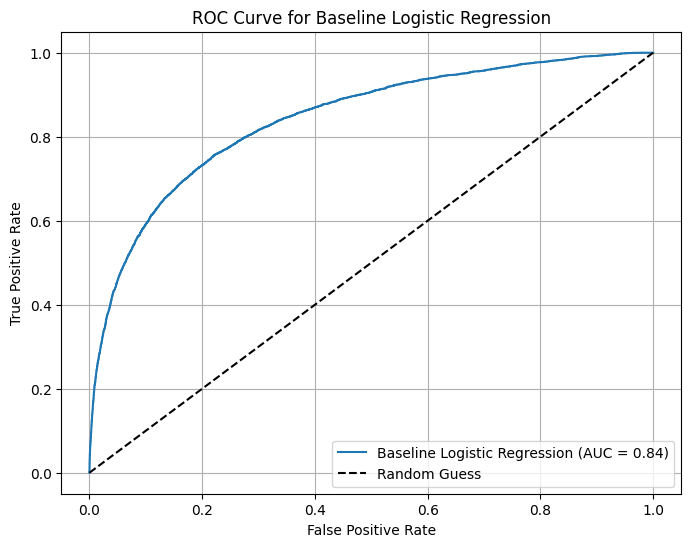

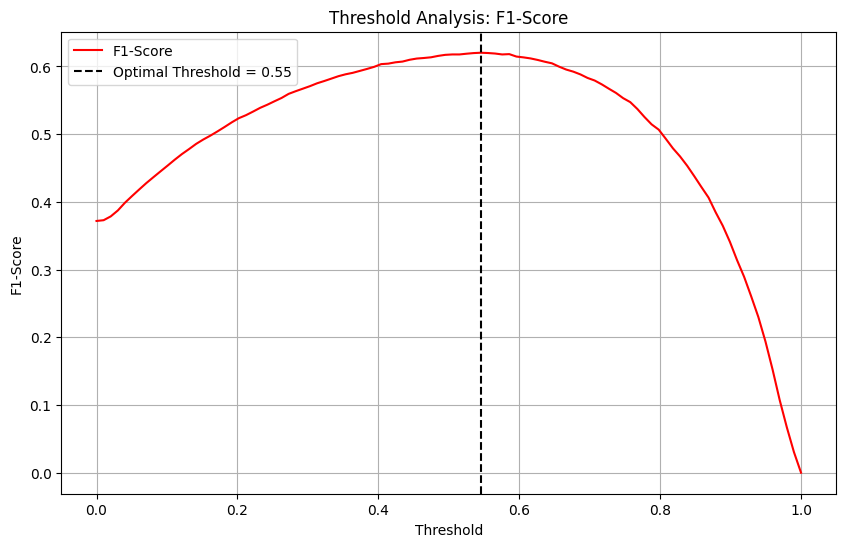

Optimal Threshold: 0.55
Optimal F1-Score: 0.62
Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88     20493
         1.0       0.60      0.65      0.62      6064

    accuracy                           0.82     26557
   macro avg       0.74      0.76      0.75     26557
weighted avg       0.82      0.82      0.82     26557



In [ ]:
baseline_model, baseline_metrics = train_and_evaluate_logistic_regression(
    X_train, X_test, y_train, y_test,
    class_weight=None,
    title="Baseline Logistic Regression"
)

y_pred_prob = baseline_model.predict_proba(X_test)[:, 1]

optimal_threshold, f1_scores = find_optimal_threshold(y_test, y_pred_prob)

y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

print("Classification Report at Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

Analysis (Baseline Logistic Regression):  
Precision (positive target class) - tells that out of all predicted rainy tomorrows only 56% are correct;  
Recall (positive target class) - tells that out of all real rainy tommorows model identifies correctly only 69%;  
f-1 score is 62%, which is just harmonic mean of two precision and recall;

ROC , AUC interpretations
AUC value is pretty high , equal to 0.84 , which means that model can accurately distinguish between two classes RainTomorrow == 1 and RainTomorrow == 0.
From curve we see that curve rises sharply at the beginning which indicates that the model achieves a high True Positive Rate (Recall) with minimal False Positives at early thresholds. But such behaviour lasts not very long , and after certain period decreasing threshold results in small increase of true positive rate and much bigger increase in False Positive Rate (curve flattens)

Optimal threshold was chosen by applying different thresholds and calculating f-1 score of predictions using that threshold, then that threshold was chosen which gives the highest f-1 metric on predictions. In this case choosing optimal threshold did not give any improvement of f-1 score(it remained of value 0.62).

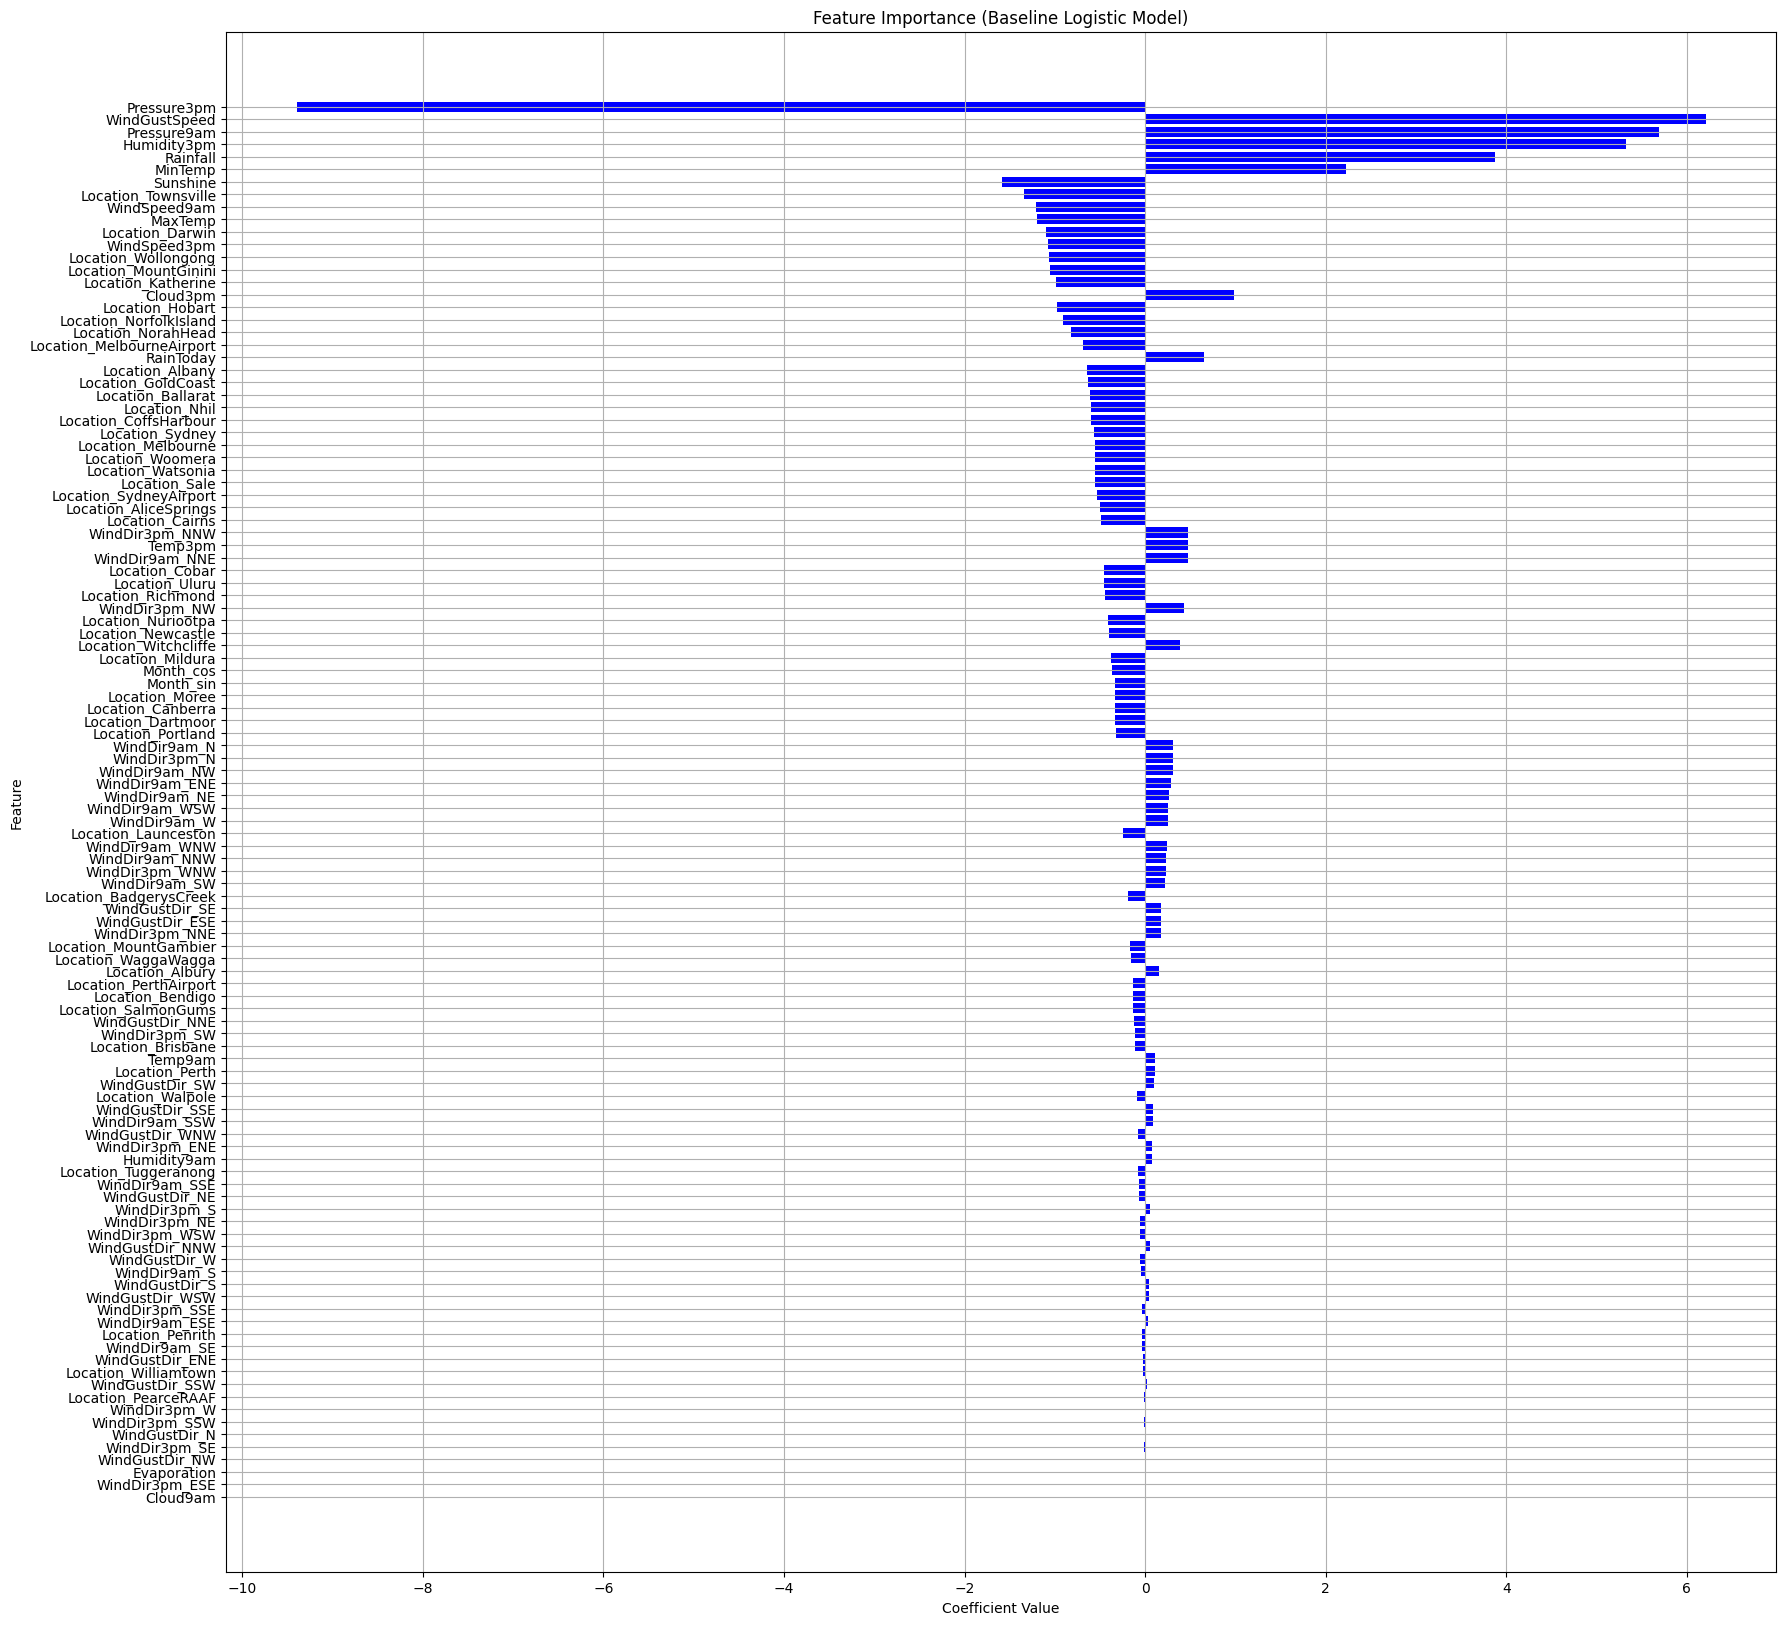

In [ ]:
feature_importance = plot_model_coefficients(baseline_model,feature_names,title="Feature Importance (Baseline Logistic Model)")

Can be seen that model (baseline) primarily relies on features from dataset (importance in descending order): (Negative relationship with target) Pressure3pm, WindGustSpeed (Positive relationship with target), Pressure9am(Positive relationship with target), Humidity3pm(Positive relationship with target), Rainfall(Positive relationship with target), MinTemp(Positive relationship with target), we could say that those features are the most important in predicting whether tomorrow will rain or not. So we can say that it is likely that model will make a prediction that tomorrow will rain if: today pressure at 3pm was low, the maximum speed of wind today was high, pressure at 9am was also high, humidity at 3pm today was high and rainfall value was also high today.

After these features we see that also feature sunshine impacts target feature, with negative relationship, which is natural: more hours sun shines today less likely that tomorrow will be raining.     
Also we see that there are some important features related to location on which our models also relies. (But the impact is rather small comparing to already described above features).

Classification Report for Weighted Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.92      0.77      0.84     20493
         1.0       0.50      0.76      0.60      6064

    accuracy                           0.77     26557
   macro avg       0.71      0.77      0.72     26557
weighted avg       0.82      0.77      0.78     26557

Accuracy: 0.77
AUC: 0.84


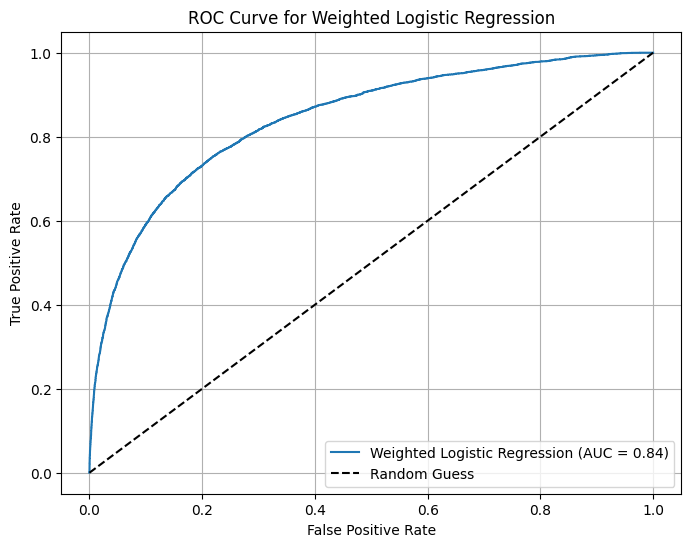

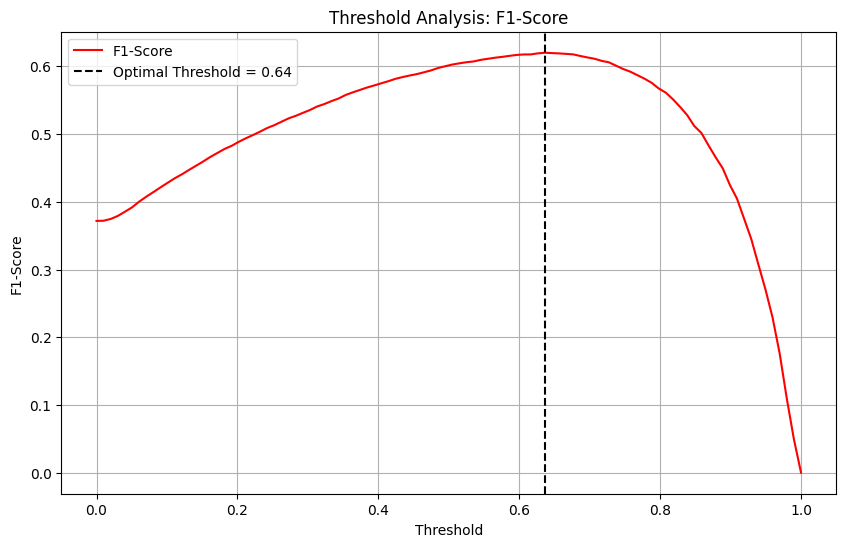

Optimal Threshold: 0.64
Optimal F1-Score: 0.62
Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88     20493
         1.0       0.59      0.65      0.62      6064

    accuracy                           0.82     26557
   macro avg       0.74      0.76      0.75     26557
weighted avg       0.82      0.82      0.82     26557



In [ ]:
weighted_model, weighted_metrics = train_and_evaluate_logistic_regression(
    X_train, X_test, y_train, y_test,
    class_weight='balanced',
    title="Weighted Logistic Regression"
)

y_pred_prob = weighted_model.predict_proba(X_test)[:, 1]

optimal_threshold, f1_scores = find_optimal_threshold(y_test, y_pred_prob)

y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

print("Classification Report at Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

Analysis (Weighted Logistic Regression):  
Precision (positive target class) - tells that out of all predicted rainy tomorrows only 50% are correct;  
Recall (positive target class) - tells that out of all real rainy tommorows model identifies correctly only 76%;  
f-1 score is 60%, which is just harmonic mean of two precision and recall;

Weighting affect:
after applying automated weighting to model we can see that it started to predict more frequently minority class "RainTomorrow == 1", which increased recall and decreased precision. (comparing to baseline model without weighting)

In this case model with higher rate identifies real rainy tomorrows, though the precision has decreased (comparing to baseline). Basically, we can say that in weighted model more positive predictions are made, which increases rate of False Positives and decreases rate of False Nagetives.

ROC , AUC interpretations
AUC value is pretty high , equal to 0.84 , which means that model can accurately distinguish between two classes RainTomorrow == 1 and RainTomorrow == 0.
From curve we see that curve rises sharply at the beginning which indicates that the model achieves a high True Positive Rate (Recall) with minimal False Positives at early thresholds. But such behaviour lasts not very long , and after certain period increasing threshold results in  small increase of true positive rate and much bigger increase in False Positive Rate (curve flattens)

The same procedure of finding optimal threshold was applied, in this case f-1 score (poitive class) has increased after choosing optimal threshold(from 0.6 to 0.62).

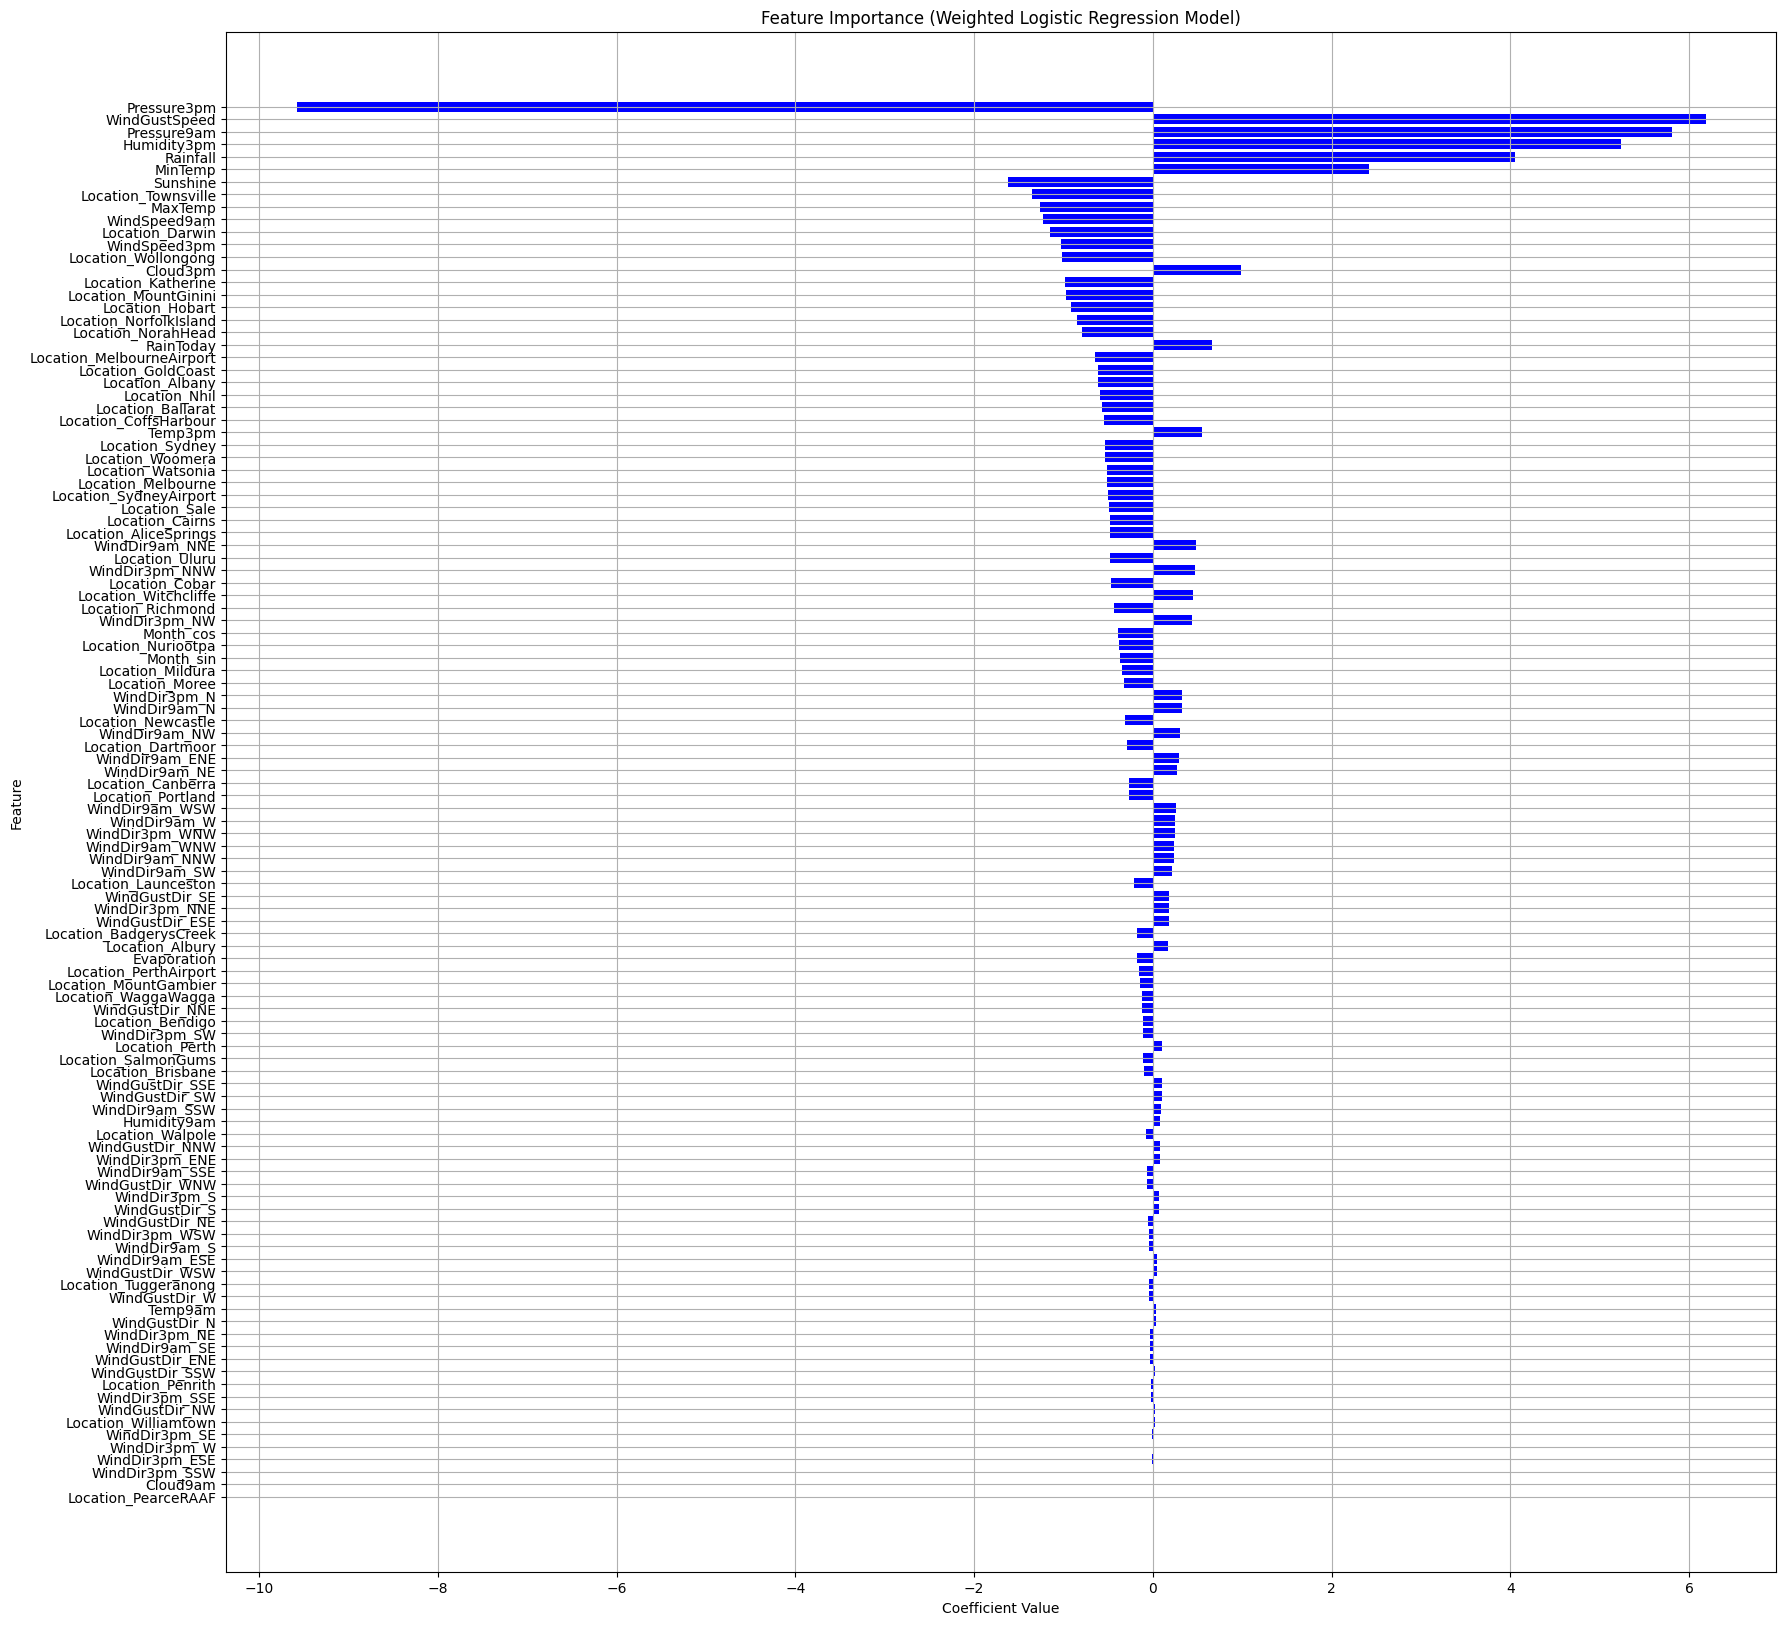

In [ ]:
feature_importance = plot_model_coefficients(weighted_model,feature_names,title="Feature Importance (Weighted Logistic Regression Model)")

Feature importance interpretation: it can be seen that most important features in this weighted model are the same as in baseline.

Classification Report for ElasticNet Logistic Regression with Weighting:
              precision    recall  f1-score   support

         0.0       0.92      0.77      0.84     20493
         1.0       0.50      0.76      0.60      6064

    accuracy                           0.77     26557
   macro avg       0.71      0.77      0.72     26557
weighted avg       0.82      0.77      0.78     26557

Accuracy: 0.77
AUC: 0.84


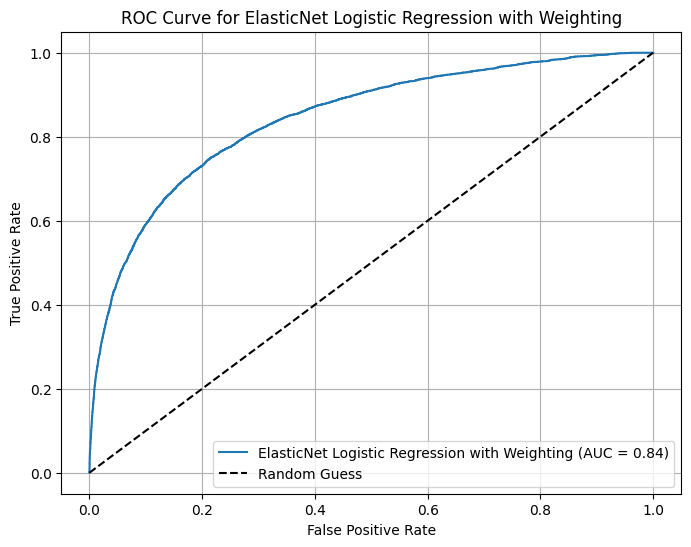

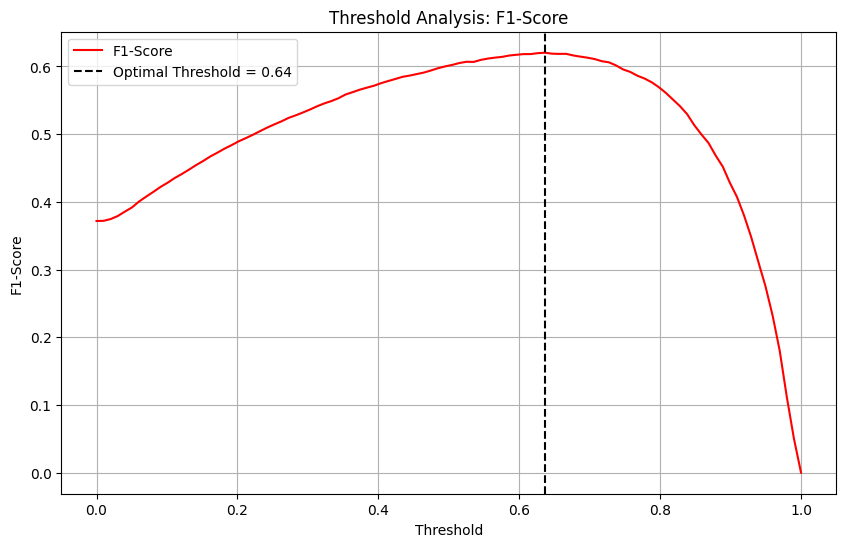

Optimal Threshold: 0.64
Optimal F1-Score: 0.62
Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88     20493
         1.0       0.59      0.65      0.62      6064

    accuracy                           0.82     26557
   macro avg       0.74      0.76      0.75     26557
weighted avg       0.82      0.82      0.82     26557



In [ ]:
elasticnet_weighted_model, elasticnet_weighted_metrics = train_and_evaluate_logistic_regression(
    X_train, X_test, y_train, y_test,
    class_weight='balanced',
    penalty='elasticnet',
    l1_ratio=0.5,
    title="ElasticNet Logistic Regression with Weighting"
)

y_pred_prob = elasticnet_weighted_model.predict_proba(X_test)[:, 1]

optimal_threshold, f1_scores = find_optimal_threshold(y_test, y_pred_prob)

y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

print("Classification Report at Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

Analysis (ElasticNet Logistic regression with Weighting):  
Precision (positive target class) - tells that out of all predicted rainy tomorrows only 50% are correct;  
Recall (positive target class) - tells that out of all real rainy tommorows model identifies correctly only 76%;  
f-1 score is 60%, which is just harmonic mean of two precision and recall;
We can see that adding to a model linearly combined the L1 and L2 penalties did not give any improvement comparing to previous (just weighted model)

ROC , AUC interpretations
AUC value is pretty high , equal to 0.84 , which means that model can accurately distinguish between two classes RainTomorrow == 1 and RainTomorrow == 0.
From curve we see that curve rises sharply at the beginning which indicates that the model achieves a high True Positive Rate (Recall) with minimal False Positives at early thresholds. But such behaviour lasts not very long , and after certain period increasing threshold results in  small increase of true positive rate and much bigger increase in False Positive Rate (curve flattens)

The same procedure of finding optimal threshold was applied, in this case f-1 score (poitive class) has increased after choosing optimal threshold(from 0.6 to 0.62).

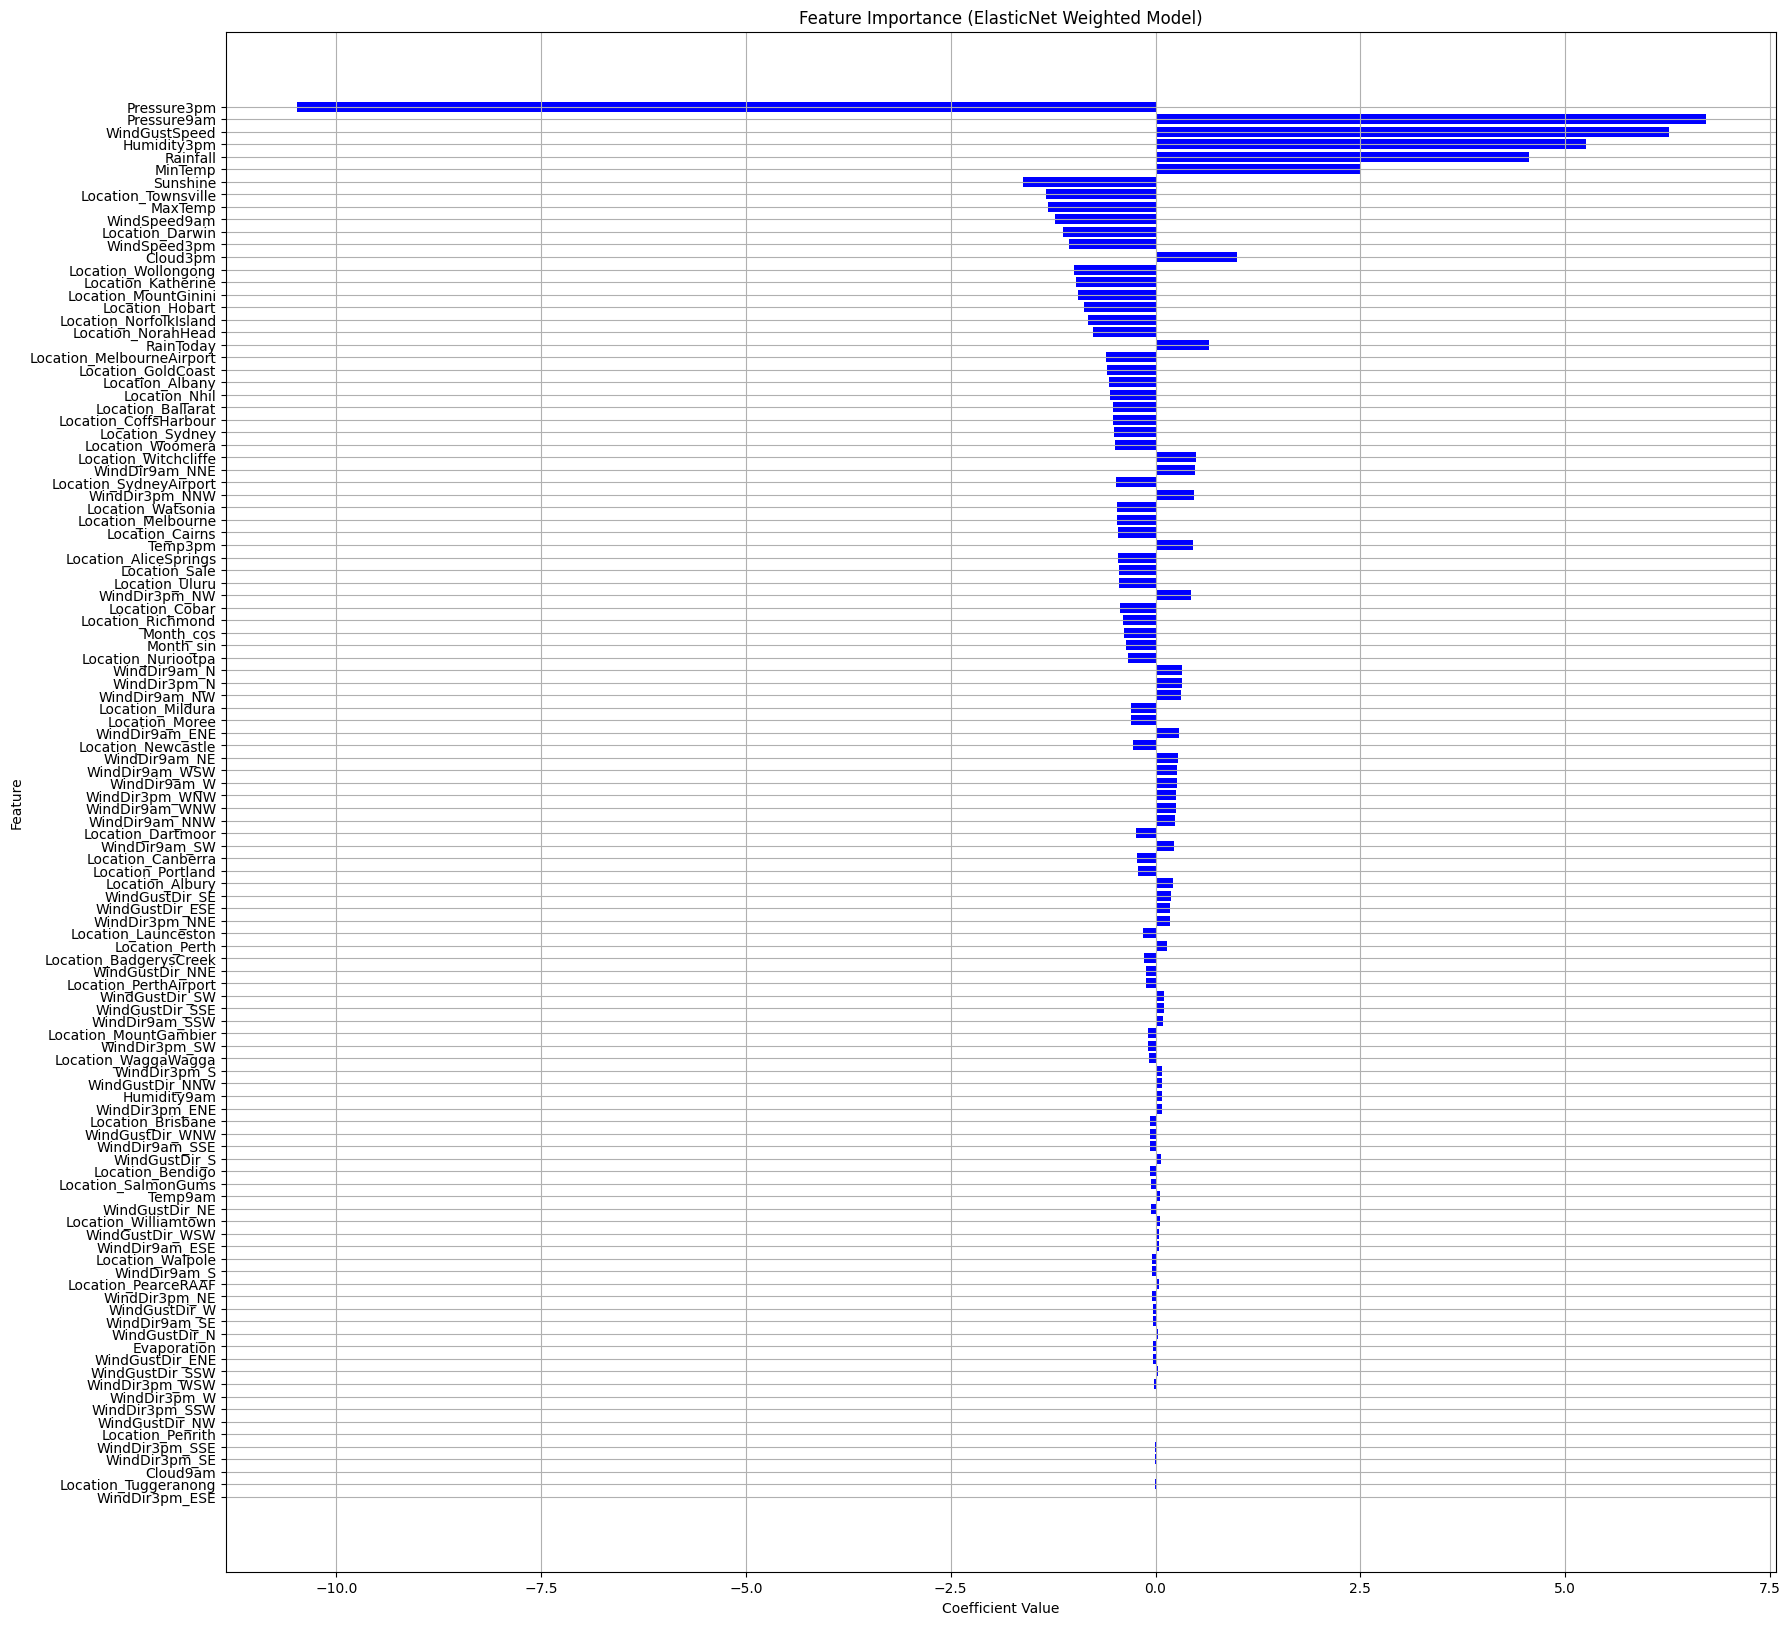

In [ ]:
feature_importance = plot_model_coefficients(elasticnet_weighted_model,feature_names,title="Feature Importance (ElasticNet Weighted Model)")

Here we see the same feature importnce plot, only one difference: feature pressure9am impacts target feature more than feature windgustspeed, which was opposite in previous two models. Except this all other most important features stayed at the same places.

Logistic models comparison:   
We see that weighted logistic regression and elasticnet logistic regression with weighting give the highest recall metric value, but from other side baseline gave us the highest among all three models f-1 score.
No difference in perfomance found between weighted logistic regression and elasticnet logistic regression. As we are trying to maximize f-1 score , i would say that baseline model is the best out of all three presented above.

We have seen that auc score for models is the same , it is very high. Also have been seen that roc curve is also almost the same for all three models, it has the similiar curvature, from this can be concluded that tradeoff between true positives and false positives changes the same way for all three models while changing the threshold applied.

For last elasticnet logistic regression with weighting will be performed parameter tuning.

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    class_weight='balanced',
)

scorer = make_scorer(f1_score, pos_label=1)

gs = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)

print("Best Parameters:", gs.best_params_)
print("Best F1-Score:", gs.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'C': 100, 'l1_ratio': 0.7}
Best F1-Score: 0.7398221822833195


After hyperparameter tuning, we see that for set of parameters {C = 100, l1_ratio = 0.7}, f-1 score reaches its maximal value of 0.7, which have not been reached in previous three models. This model could be further considered , developed , investigated , as it would probably have highest value of f-1 metric on test set, but that needs to be discoveered.

**KNN algorithm**

In [ ]:
def train_and_evaluate_knn(X_train, X_test, y_train, y_test, n_neighbors=5, title="KNN Classifier"):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    report = classification_report(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    print(f"Classification Report for {title} (n_neighbors={n_neighbors}):")
    print(report)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC: {auc:.2f}")

    metrics = {
        'accuracy': accuracy,
        'auc': auc,
        'classification_report': report
    }
    return model, metrics, fpr, tpr

def plot_roc_curves_knn(models_data):
    plt.figure(figsize=(10, 8))
    for data in models_data:
        plt.plot(
            data['fpr'], data['tpr'],
            label=f"{data['name']} (AUC = {data['auc']:.2f})"
        )
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for KNN Classifiers with Different Neighbors')
    plt.legend()
    plt.grid()
    plt.show()

Classification Report for KNN Classifier (n_neighbors=3):
              precision    recall  f1-score   support

         0.0       0.85      0.78      0.81     20493
         1.0       0.41      0.53      0.47      6064

    accuracy                           0.72     26557
   macro avg       0.63      0.65      0.64     26557
weighted avg       0.75      0.72      0.73     26557

Accuracy: 0.72
AUC: 0.70
Classification Report for KNN Classifier (n_neighbors=5):
              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82     20493
         1.0       0.43      0.55      0.48      6064

    accuracy                           0.73     26557
   macro avg       0.64      0.67      0.65     26557
weighted avg       0.76      0.73      0.74     26557

Accuracy: 0.73
AUC: 0.73
Classification Report for KNN Classifier (n_neighbors=10):
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85     20493
         1.0

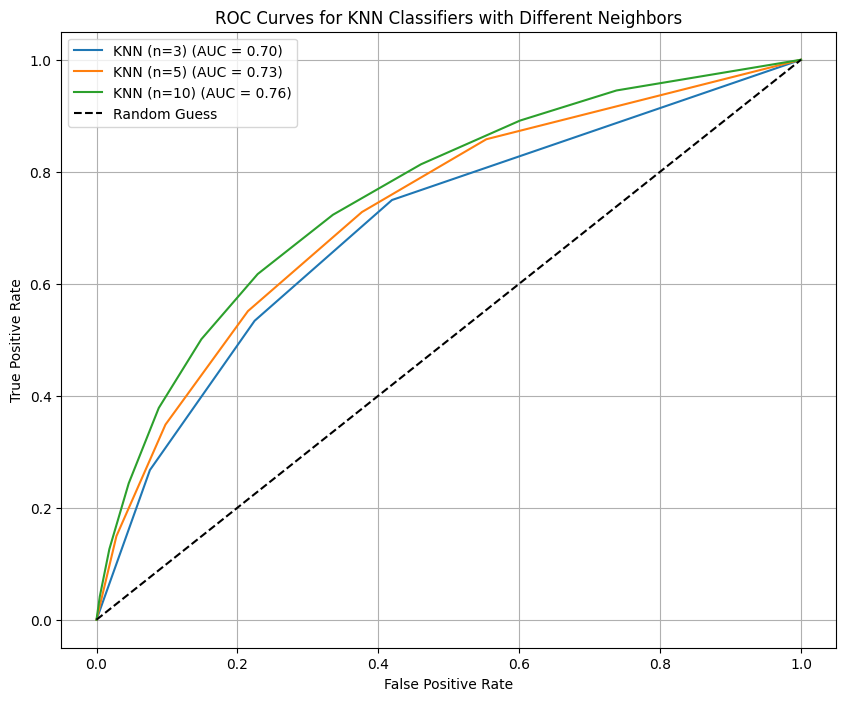

In [ ]:
models_data = []

for n in [3, 5, 10]:
    model, metrics, fpr, tpr = train_and_evaluate_knn(
        X_train, X_test, y_train, y_test,
        n_neighbors=n,
        title="KNN Classifier"
    )
    models_data.append({'name': f'KNN (n={n})', 'fpr': fpr, 'tpr': tpr, 'auc': metrics['auc']})

plot_roc_curves_knn(models_data)

Can be seen that with increasing number of neighbours in models precision and recall for positive class(rain tomorrow==1) are also increasing , though it seen that still they are very low, with the best result for last model (Precision = 0.5 and Recall = 0.5). Which means that for best out of these three models only 50% of positively predicted are predicted correctly (precision) and only 50% of all real positives are predicted as being positives(recall). This makes KNN classifier worse than Logistic regression models trained before, if we look at this parameters.

Looking at AUC, it is of good value , as it is equal to: 0.7 (KNN, n_neigh=3), 0.73 (KNN, n_neigh=5), 0.76 (KNN, n_neigh=10). Which means that classsifiers can distinguish with good extent between two classes RainTomorrow == 1 and RainTomorrow == 0, but obviously do this worse than any previously trained logistic regression model.

We also see the same pattern (AUC increases with increasing number of neigbours in classifier), we see that from plots. Also we see that steepnest and shape all three urves are almost same, they look similiar, which suggest us that the tradeoff between false positives and true positives changes with the same rate for all three KNN models , as we change the threshold.

As we have seen bigger number of neigbours in model gives better f-1 score and AUC, for that reason will be tuned hyperparameter (n_neighbours) with high availbale values (15, 20, 25).

In [ ]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [15, 20, 25],
    'weights': ['uniform', 'distance'],
}

scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring=scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'n_neighbors': 25, 'weights': 'distance'}
Best F1-Score: 0.6267155849559253


We see that after applying hyperparameters tuning, best hyperparameters are (number of neighbours is equal to 25 and another one - weights is equal to distance, which means that closer neighbors of a query point will have a greater influence than neighbors which are further away), such set of hyperparameters gave us the highest seen in this notebook f-1 score (positive class) equal to ~ 0.63. Which can be compared to logistic regression models(not fine tuned), as they mostly also had around that value for metric f-1.

**Naive Bayes**

In [ ]:
def train_and_evaluate_naive_bayes(X_train, X_test, y_train, y_test, class_prior=None, title="Naive Bayes"):
    model = GaussianNB(priors=class_prior)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    report = classification_report(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    print(f"Classification Report for {title}:")
    print(report)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC: {auc:.2f}")

    metrics = {
        'accuracy': accuracy,
        'auc': auc,
        'classification_report': report
    }
    return model, metrics, fpr, tpr


def plot_roc_curves_naive_bayes(models_data):
    plt.figure(figsize=(10, 8))
    for data in models_data:
        plt.plot(
            data['fpr'], data['tpr'],
            label=f"{data['name']} (AUC = {data['auc']:.2f})"
        )
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Naive Bayes Models')
    plt.legend()
    plt.grid()
    plt.show()

Will be used as baseline basic Naive Bayes classifier, we can use it on our data though it contains initially non normally distributed numerical features, but as they were normalized , the scale is now the same for all features, so it would be more or less approriate on such data gaussian naive bayes classifier. Other two modifications will be with weightining included: the misclassification of positive class will be penalized more (so to show model that we care about that positive class more, to mitigate target classes imbalance in training dataset)

Classification Report for Baseline Naive Bayes:
              precision    recall  f1-score   support

         0.0       0.87      0.61      0.72     20493
         1.0       0.34      0.69      0.46      6064

    accuracy                           0.63     26557
   macro avg       0.61      0.65      0.59     26557
weighted avg       0.75      0.63      0.66     26557

Accuracy: 0.63
AUC: 0.71
Classification Report for Naive Bayes with Class Prior:
              precision    recall  f1-score   support

         0.0       0.87      0.59      0.70     20493
         1.0       0.34      0.71      0.46      6064

    accuracy                           0.61     26557
   macro avg       0.60      0.65      0.58     26557
weighted avg       0.75      0.61      0.64     26557

Accuracy: 0.61
AUC: 0.71
Classification Report for Naive Bayes with Heavier Class Prior:
              precision    recall  f1-score   support

         0.0       0.87      0.57      0.69     20493
         1.0       

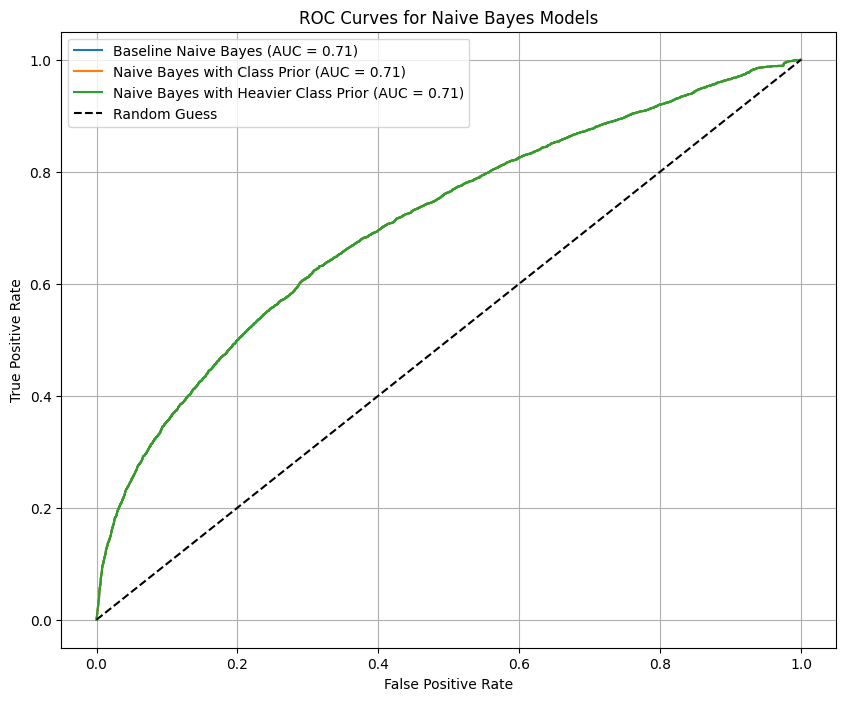

In [ ]:
models_data = []

model_baseline, metrics_baseline, fpr_baseline, tpr_baseline = train_and_evaluate_naive_bayes(
    X_train, X_test, y_train, y_test,
    title="Baseline Naive Bayes"
)
models_data.append({'name': 'Baseline Naive Bayes', 'fpr': fpr_baseline, 'tpr': tpr_baseline, 'auc': metrics_baseline['auc']})

class_prior = [0.4, 0.6]
model_weighted, metrics_weighted, fpr_weighted, tpr_weighted = train_and_evaluate_naive_bayes(
    X_train, X_test, y_train, y_test,
    class_prior=class_prior,
    title="Naive Bayes with Class Prior"
)
models_data.append({'name': 'Naive Bayes with Class Prior', 'fpr': fpr_weighted, 'tpr': tpr_weighted, 'auc': metrics_weighted['auc']})

class_prior = [0.3, 0.7]
model_weighted2, metrics_weighted2, fpr_weighted2, tpr_weighted2 = train_and_evaluate_naive_bayes(
    X_train, X_test, y_train, y_test,
    class_prior=class_prior,
    title="Naive Bayes with Heavier Class Prior"
)
models_data.append({'name': 'Naive Bayes with Heavier Class Prior', 'fpr': fpr_weighted2, 'tpr': tpr_weighted2, 'auc': metrics_weighted2['auc']})

plot_roc_curves_naive_bayes(models_data)

Evaluation comments of each Naive Bayes:
1) Baseline
(for positive class)has very low precision 0.34 , and pretty high recall 0.69, which means that model predicts very often that an instance if of positive class, which makes False Positive rate go up (as well as makes precision go down) and False Negatives (go down, as well as recall go up), corresponding f-1 score is not impressive and equal to 0.46  
2) Naive Bayes with Class Prior
(for positive class) there is the same precision as baseline line model had (above), recall became even higher 0.71, and the same f-1 score is equal to 0.46
3) Naive Bayes with Heavier Class Prior  
(for positive class) precision has decreased comparing two first two naive bayes models, precision is 0.33, though recall became even higher than for second naive bayes model and now is 0.72. f-1 score has also decrease a little bit and now is 0.45.  
  
so i would probably say, that out of these three models , second model , which penalizes incorrect classifications of positive class less than third one, did the best , with the highest tradeoff between recall and precision

Comparison Naive Bayes vs Other models (logistic regression, knn classifier):

if we will compare by recall (positive class), then can be concluded that any naive bayes classifier is better than any KNN classifier, that means that rates of identifying of real rainy tomorrow are higher for Naive Bayes comparing to KNN classifiers. Though f-1 score is higher for every KNN classifier than for every Naive Bayes classifier. As I told our main metric is f-1 score (optimizing it to get good tradeoff between recall and precision of positive class), so it could be conlcuded that non tuned KNN classifiers have done much better than non tuned Naive Bayes Classifiers.

Comparing every Bayes Non tuned classifier with every Logistic Regression Model by metric f-1 score, suggests us that overall every model of Logistic regression done better than Naive Bayes, though it migh had some times lower recall, but it had higher f-1 score even non-tuned, and without optimal threshold chosen.

AUC/ROC curve:
AUC is the same for all models, and as well the same for all three models ROC curve. AUC values stands as not very high, but still reasonable, with value of 0.71, which means that classsifiers can distinguish with good extent between two classes RainTomorrow == 1 and RainTomorrow == 0, but obviously do this worse than any previously trained logistic regression model, but distinguishing ability of these Naive classifiers is somewhat the same as for KNN neighbours(not finetuned)

In [ ]:
gnb = GaussianNB()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
}

scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=gnb,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'var_smoothing': 1e-09}
Best F1-Score: 0.6292080925207675


can be seen that some set of hyperparameters can lead to better f1-score metric, probably it will be about the same after testing classifier with best parameters on test set. Right now we can say , that after parameters tuning f-1 metric is close to f-1 metrics obtained after hyperparameter training of KNN classifier, but still is less than f-1 metric of tuned logistic regression. Which makes for now logistic regression the best classifier out of all.

**SVM**

In [ ]:
def train_and_evaluate_svm(X_train, X_test, y_train, y_test, class_weight=None, kernel='linear', title="SVM"):
    model = SVC(
        kernel=kernel,
        class_weight=class_weight,
        probability=True,
        random_state=42,
        max_iter=1000
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    report = classification_report(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    print(f"Classification Report for {title}:")
    print(report)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC: {auc:.2f}")

    metrics = {
        'accuracy': accuracy,
        'auc': auc,
        'classification_report': report
    }
    return model, metrics, fpr, tpr

def plot_roc_curves_svm(models_data):
    plt.figure(figsize=(10, 8))
    for data in models_data:
        plt.plot(
            data['fpr'], data['tpr'],
            label=f"{data['name']} (AUC = {data['auc']:.2f})"
        )
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for SVM Models')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
models_data = []

model_baseline, metrics_baseline, fpr_baseline, tpr_baseline = train_and_evaluate_svm(
    X_train, X_test, y_train, y_test,
    kernel='linear',
    title="Baseline SVM (Linear Kernel)"
)
models_data.append({'name': 'Baseline SVM (Linear Kernel)', 'fpr': fpr_baseline, 'tpr': tpr_baseline, 'auc': metrics_baseline['auc']})

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Classification Report for Baseline SVM (Linear Kernel):
              precision    recall  f1-score   support

         0.0       0.84      0.61      0.71     20493
         1.0       0.31      0.59      0.41      6064

    accuracy                           0.61     26557
   macro avg       0.57      0.60      0.56     26557
weighted avg       0.72      0.61      0.64     26557

Accuracy: 0.61
AUC: 0.64


F-1 score is lower than f-1 score of svm with rbf kernel, but higher than SVM with class weighting (and linear kernel). The model overall is also bad as the next one, as the f-1 score is pretty low, though recall value is around of moderate value.

In [ ]:
model_weighted, metrics_weighted, fpr_weighted, tpr_weighted = train_and_evaluate_svm(
    X_train, X_test, y_train, y_test,
    class_weight='balanced',
    kernel='linear',
    title="SVM with Class Weighting (Linear Kernel)"
)
models_data.append({'name': 'SVM with Class Weighting (Linear Kernel)', 'fpr': fpr_weighted, 'tpr': tpr_weighted, 'auc': metrics_weighted['auc']})

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Classification Report for SVM with Class Weighting (Linear Kernel):
              precision    recall  f1-score   support

         0.0       0.66      0.08      0.15     20493
         1.0       0.22      0.86      0.35      6064

    accuracy                           0.26     26557
   macro avg       0.44      0.47      0.25     26557
weighted avg       0.56      0.26      0.19     26557

Accuracy: 0.26
AUC: 0.40


Can be seen that models detect 86% rainy tomorrow from all set of real rainy tomorrows, but the accuracy with which it does that is very low, which means that we can be highly unsure whther next predicted rainy tomorrow will be a real one. In our system of coordinate, the model is bad, as f1-score is very low. Also this model is the worst across all three svm classifiers presented in this notebook.
  
The last SVM classsifier with RBF kernel is the best accross all SVM classifiers presented here , as its f1-score is the highest across them , and equal to 0.45, the recall and precision are very bad though for this classifier too.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Classification Report for SVM with RBF Kernel:
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84     20493
         1.0       0.45      0.44      0.45      6064

    accuracy                           0.75     26557
   macro avg       0.64      0.64      0.64     26557
weighted avg       0.75      0.75      0.75     26557

Accuracy: 0.75
AUC: 0.71


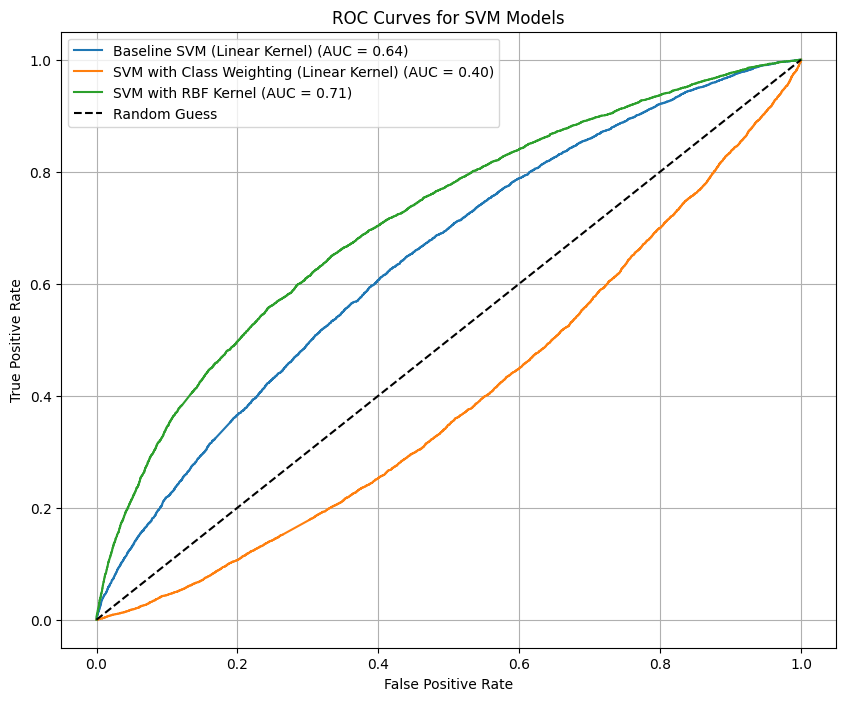

In [ ]:
model_rbf, metrics_rbf, fpr_rbf, tpr_rbf = train_and_evaluate_svm(
    X_train, X_test, y_train, y_test,
    kernel='rbf',
    title="SVM with RBF Kernel"
)
models_data.append({'name': 'SVM with RBF Kernel', 'fpr': fpr_rbf, 'tpr': tpr_rbf, 'auc': metrics_rbf['auc']})

plot_roc_curves_svm(models_data)

Overall, svm classisfiers did worst job across all classifiers: Logistic Regression Classifier, Naive Bayeses, KNN classifiers. The conclusion is based on comparing f1-scores between all svm classifiers and all other models f1-scores.

Comparison of AUC and ROC curves for different versions of SVM classifiers:
Can be seen that svm classifier with class weighting has fone worse than random guessing baseline model. Its AUC is equal to 0.4, it the worst result across all classifiers trained in this notebook.   
We can see that The best AUC belongs to SVM with RBF kernel, it is equal to 0.71, which can be compared with similiar AUC scores for KNN classifiers (all untuned) and for Naive Bayeses (all untuned). And still AUC score is much lower for every SVM classifier compared to any Logistic regression classifier.   
The baseline AUC score is 0.64, which also makes it the worst classifier (comapring by this score) to all others seen in this notebook, but at least better SVM classifier with class weighting.

In [ ]:
svm = SVC(probability=True, random_state=42, max_iter = 1000)

param_grid = {
    'C': [10, 100],
    'kernel': ['rbf', 'poly']
}

scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring=scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'C': 100, 'kernel': 'poly'}
Best F1-Score: 0.4944115198032148


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


After running hyper parameters tuning for svm classifier we see , that it found out of predefined hyperparameters the best set, that maximizes f1-score, though it is still pretty low.

Maybe such poor metrics were obtained by SVM classifiers due to setting maximum iterations to specific value, so it was not enough time (iterations) for SVM to converge for better parameters and find most optimal solution. But without setting this parameter it have been taking too long to train SVM classifiers, maybe that is due large feature space of training set.

**Conclusion**  
Can be seen that Logistic regression classifiers were best while dealing with this problem, as they had highest f1-metrics (positive class) across all other classifiers (KNN classifiers, Naive Bayes classifiers, SVM classifiers). Further use of fined tuned Logistic Regression Classifier would result in even better f1-score value.